In [1]:
import numpy as np
import xarray as xr
import MJO_E3SM_util as mjo
import pandas as pd 
import matplotlib.pyplot as plt
import glob 
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [64]:
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
z200 = pickle.load(open(dirn+'analysis/u200_composite_control_latavg.json', 'rb'))
olr = pickle.load(open(dirn+'analysis/olr_composite_control_latavg.json', 'rb'))

<xarray.DataArray 'Z3' (lat: 30, lon: 180)>
array([[ 7.372467 ,  7.4442644,  7.6416674, ...,  7.412132 ,  7.3657136,
         7.360646 ],
       [ 8.780922 ,  8.929411 ,  9.165982 , ...,  8.653653 ,  8.695264 ,
         8.737457 ],
       [ 9.686132 ,  9.878414 , 10.141389 , ...,  9.457621 ,  9.548728 ,
         9.576464 ],
       ...,
       [ 6.925078 ,  7.054807 ,  7.210947 , ...,  6.4542127,  6.577971 ,
         6.7494073],
       [ 6.661835 ,  6.7233834,  6.7578673, ...,  6.295163 ,  6.378563 ,
         6.509856 ],
       [ 6.1238437,  6.0505075,  5.8820834, ...,  5.95435  ,  5.974271 ,
         6.0446258]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -29.0 -27.0 -25.0 -23.0 -21.0 ... 23.0 25.0 27.0 29.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
    lev      float64 195.1

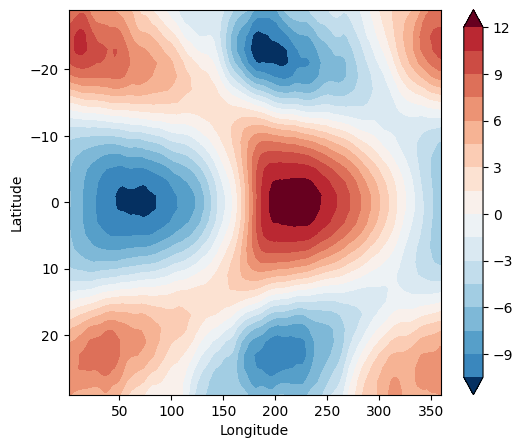

In [67]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.contourf(z200['lon'], z200['lat'], z200, cmap='RdBu_r', vmin= -15, vmax=15, levels=21, extend='both')
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.colorbar(im)

In [39]:
def get_horizontal_from_3D(var_name, lev_slice, case_dir='control', lat_lim=30):
    # directory that stores all case data
    dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
    lat_lim_olr = 10
    files_path = dirn + case_dir + '/'

    # Find all .nc files in the directory
    nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
    ndays = 200
    ds1 = xr.open_mfdataset(nc_files[:ndays])

    # average the OLR over 10S-10N
    olr = ds1['FLNT'].sel(lat=slice(-lat_lim_olr,lat_lim_olr)).resample(time='1D').mean().load()
    olravg = olr.mean(dim='lat') # average over 10S-10N
    olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)
    # get the location of the miminum OLR
    olrmin = olrflt.argmin(dim='lon')

    # get the horizontal slice of the variable
    files_path = dirn + case_dir + '/3D/'
    # Find all .nc files in the directory
    nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
    ds = xr.open_mfdataset(nc_files[-ndays:])

    geop = ds[var_name].sel(lev=lev_slice, method='nearest').sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()

    mse_ano = geop - geop.mean(dim='lon')
    mse_sft = mse_ano.copy()

    for i in range(olrmin.size):
        mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

    tmp = mse_sft.mean(dim='time')

    return tmp
    


In [40]:
def get_vertical_from_3D(var_name, case_dir='control', lat_lim=10):
    # directory that stores all case data
    dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
    lat_lim_olr = 10
    files_path = dirn + case_dir + '/'

    # Find all .nc files in the directory
    nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
    ndays = 200
    ds1 = xr.open_mfdataset(nc_files[:ndays])

    # average the OLR over 10S-10N
    olr = ds1['FLNT'].sel(lat=slice(-lat_lim_olr,lat_lim_olr)).resample(time='1D').mean().load()
    olravg = olr.mean(dim='lat') # average over 10S-10N
    olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)
    # get the location of the miminum OLR
    olrmin = olrflt.argmin(dim='lon')

    # get the horizontal slice of the variable
    files_path = dirn + case_dir + '/3D/'
    # Find all .nc files in the directory
    nc_files = sorted(glob.glob(f"{files_path}/*.nc"))
    ds = xr.open_mfdataset(nc_files[-ndays:])

    geop = ds[var_name].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()

    mse_ano = geop.mean(dim='lat') - geop.mean(dim=['lon','lat'])  # time, lev, lon
    mse_sft = mse_ano.copy()

    for i in range(olrmin.size):
        mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

    tmp = mse_sft.mean(dim='time')

    return tmp
    


In [41]:
tmp = get_vertical_from_3D('U')


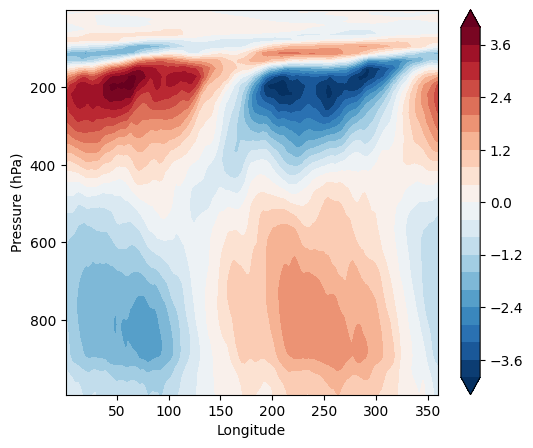

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.contourf(tmp['lon'], tmp['lev'], tmp, cmap='RdBu_r', vmin= -4, vmax=4, levels=21, extend='both')
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(im)

In [44]:
geop = get_vertical_from_3D('Z3')

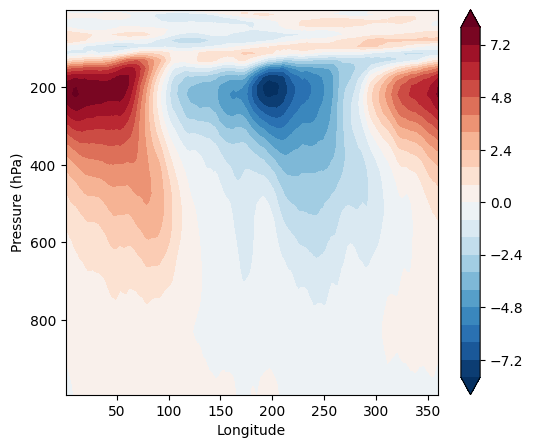

In [46]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.contourf(geop['lon'], geop['lev'], geop, cmap='RdBu_r', vmin= -8, vmax=8, levels=21, extend='both')
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(im)

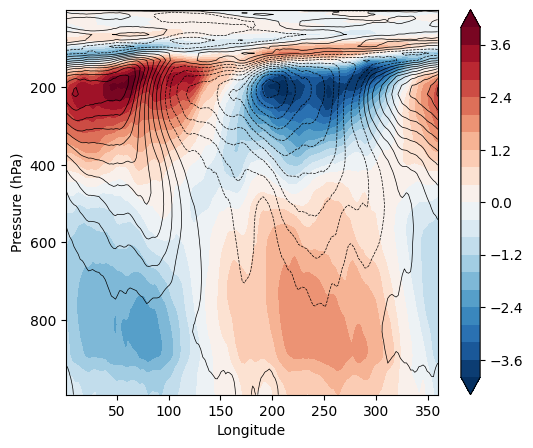

In [50]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.contourf(tmp['lon'], tmp['lev'], tmp, cmap='RdBu_r', vmin= -4, vmax=4, levels=21, extend='both')
ax.contour(geop['lon'], geop['lev'], geop, levels=21, colors='k', linewidths=0.5)
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(im)

In [51]:
omega = get_vertical_from_3D('OMEGA')

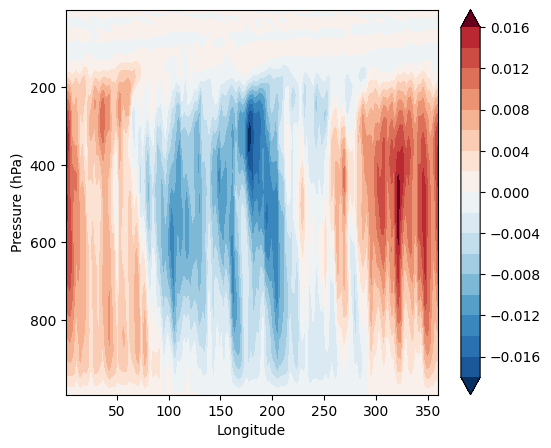

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.contourf(omega['lon'], omega['lev'], -omega, cmap='RdBu_r', vmin= -0.02, vmax=0.02, levels=21, extend='both')
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (hPa)')
plt.colorbar(im)

In [3]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'
# case_dir = 'FIX_QRT'
lat_lim = 10
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ndays = 20

ds1 = xr.open_mfdataset(nc_files[:ndays])

In [56]:
# average the OLR over 10S-10N
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()
olravg = olr.mean(dim='lat') # average over 10S-10N
olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)
# get the location of the miminum OLR
olrmin = olrflt.argmin(dim='lon')

In [4]:
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])

In [5]:
ds 

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, time: 20, nbnd: 2, lev: 60, ilev: 61,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0010-04-27 00:00:00 ... 0010-05-16 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/52)
    lat_bnds      (time, lat, nbnd) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds      (time, lon, nbnd) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1, 90), meta=np.ndarray>
    area          (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    CLDICE        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 60, 90, 180), meta=np.ndarray>
    CLDLIQ        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 60, 90, 180), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login02
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [ ]:
ds['lev'].sel(lev=500, method='nearest')

In [16]:
lat_lim = 30
geop = ds['Z3'].sel(lev=100, method='nearest').sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()

mse_ano = geop - geop.mean(dim='lon')
mse_sft = mse_ano.copy()

for i in range(olrmin.size):
    mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

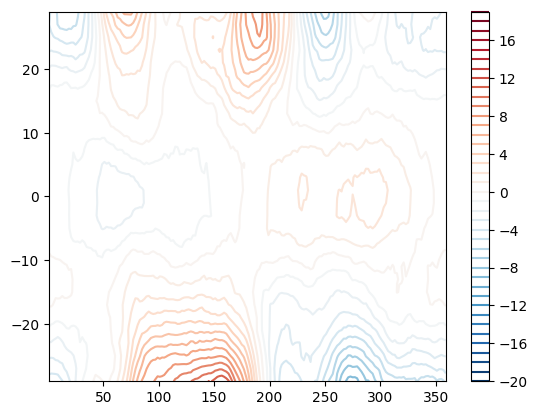

In [17]:
tmp = mse_sft.mean(dim='time')
plt.contour(tmp.lon, tmp.lat, tmp, levels=np.arange(-20, 20, 1), cmap='RdBu_r')
plt.colorbar()

In [58]:
lat_lim = 30
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()

mse_ano = olr - olr.mean(dim='lon')
mse_sft = mse_ano.copy()

for i in range(olrmin.size):
    mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

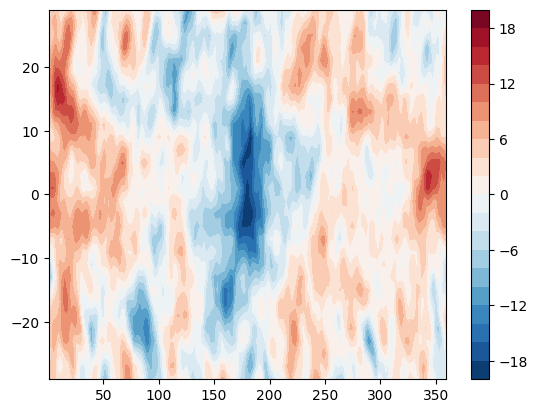

In [59]:
tmp = mse_sft.mean(dim='time')
plt.contourf(tmp.lon, tmp.lat, tmp, cmap='RdBu_r', levels=np.arange(-20, 20.1, 2))
plt.colorbar()

In [3]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'GBL_QRT'
# case_dir = 'FIX_QRT'
lat_lim = 10

ndays = 400

In [4]:
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds1 = xr.open_mfdataset(nc_files[-ndays:])
ds1

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, time: 3193, nbnd: 2, ilev: 61, lev: 60,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0008-10-14 00:00:00 ... 0009-11-17 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/54)
    lat_bnds      (time, lat, nbnd) float64 dask.array<chunksize=(8, 90, 2), meta=np.ndarray>
    lon_bnds      (time, lon, nbnd) float64 dask.array<chunksize=(8, 180, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(8, 90), meta=np.ndarray>
    area          (time, lat, lon) float64 dask.array<chunksize=(8, 90, 180), meta=np.ndarray>
    FLNS          (time, lat, lon) float32 dask.array<chunksize=(8, 90, 180), meta=np.ndarray>
    FLNT          (time, lat, lon) float32 dask.array<chunksize=(8, 90, 180), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(8, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(8,), meta=np.ndarray>
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 e8d1c25200
    product:                   model-output
    ...                        ...
    remap_hostname:            login13
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [5]:
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()
olravg = olr.mean(dim='lat') # average over 10S-10N
olravg['time'] = np.arange(olravg['time'].size)
u850 = ds1['U850'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()
u850avg = u850.mean(dim='lat') # average over 10S-10N
u850avg['time']= np.arange(olravg['time'].size)

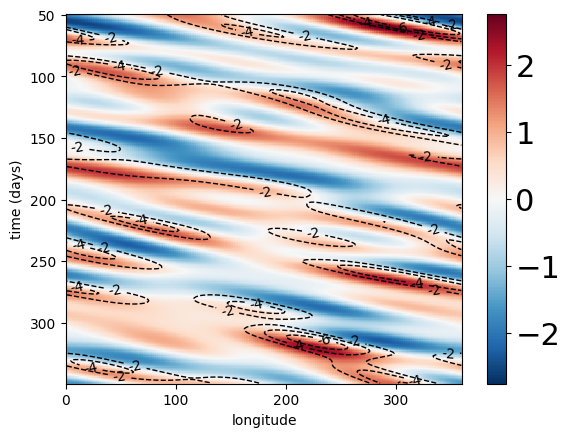

In [6]:
ude = mjo.get_MJO_signal(u850avg.load(), detrendflg=True)

u850_re = xr.DataArray(
    data=ude.real,
    coords=u850avg.coords,
    dims=u850avg.dims,
)

olrde = mjo.get_MJO_signal(olravg.load(), detrendflg=True)

olr_re = xr.DataArray(
    data=olrde.real,
    coords=olravg.coords,
    dims=olravg.dims,
)

fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 22})
# Plot u850 as a colored background
u850_re[50:350,:].plot(ax=ax, cmap='RdBu_r', add_colorbar=True)

# Add contours for negative OLR
# contour_levels = [-200, -150, -100, -50]  # customize this as needed
olr_contours = olr_re[50:350,:].where(olr_re[50:350,:] < 0).plot.contour(ax=ax, colors='k', levels=5, linewidths=1)

# Add contour labels if desired
plt.clabel(olr_contours, inline=True, fontsize=10, fmt='%1.0f')

# Add titles and labels
# plt.title('MJO-filtered u850 (colors) and negative OLR (lines)',pad=20)
plt.xlabel('longitude')
plt.ylabel('time (days)')
ax.invert_yaxis()
# Show the plot
plt.show()

## Compute the composites of the MJO based on Ma and Kuang 2011

In [6]:
# average the OLR over 10S-10N
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()
olravg = olr.mean(dim='lat') # average over 10S-10N

# filter the olr data (k=1-9, f=0.01-0.05)
# olravg[time, lon]

olrflt = mjo.get_MJO_signal(olravg, d=1, kmin=1, kmax=9, flow=0.01, fhig=0.05)

Text(0.5, 1.0, 'filtered OLR')

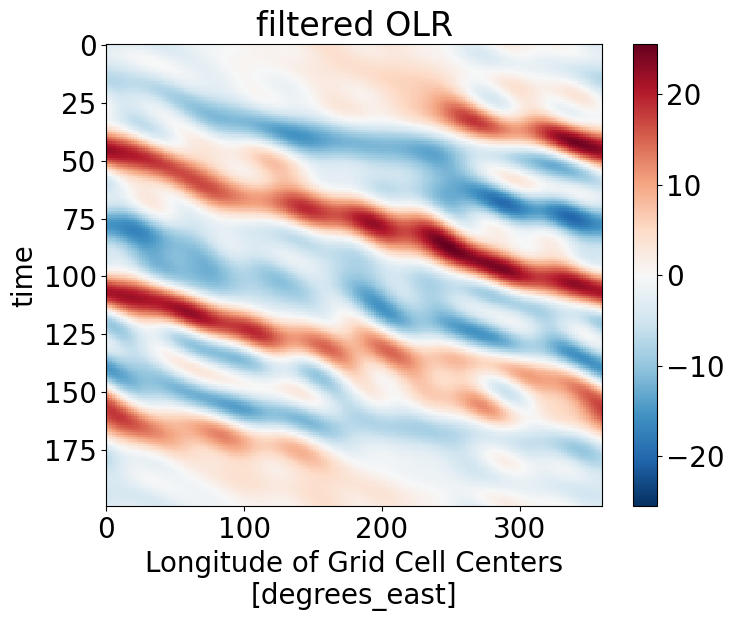

In [7]:
olr_plot = olrflt.copy()
olr_plot['time'] = np.arange(olr_plot.time.size)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(8,6))
olr_plot.plot(ax=ax)
plt.gca().invert_yaxis()
plt.title('filtered OLR')

In [12]:
# get the location of the miminum OLR
olrmin = olrflt.argmin(dim='lon')

In [17]:
# get local MSE
mse = mjo.get_local_MSE(ds, lat_lim=lat_lim, latmean=True)

In [26]:
mse_ano = mse - mse.mean(dim='lon')
mse_sft = mse_ano.copy()

for i in range(olrmin.size):
    mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

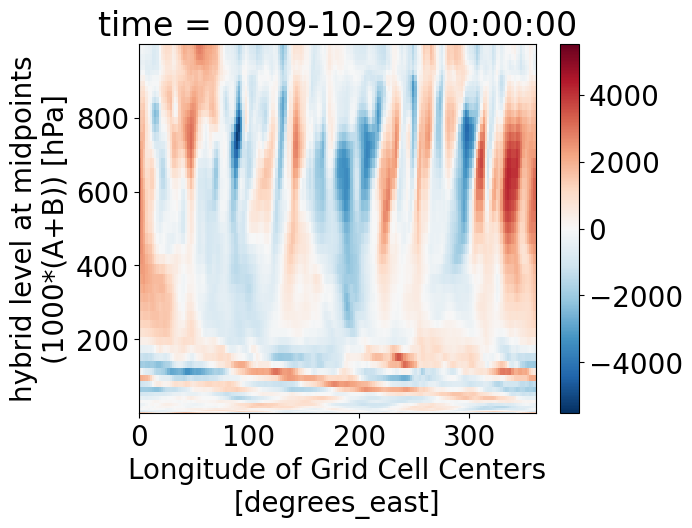

In [23]:
(mse[0,:,:]-mse[0,:,:].mean(dim='lon')).plot()

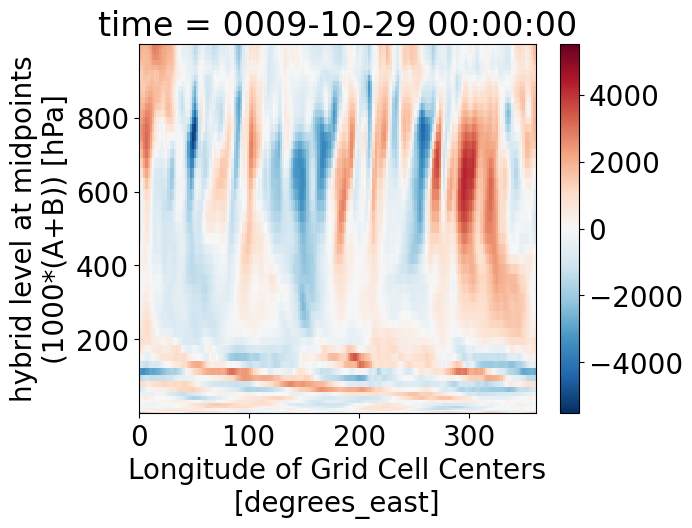

In [27]:
mse_sft[0,:,:].plot()   

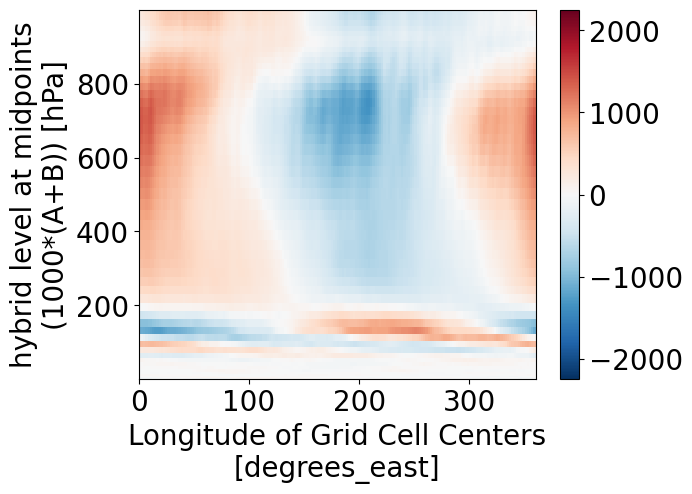

In [28]:
mse_sft.mean(dim='time').plot()

In [29]:
mse_budget = mjo.get_local_MSE_budget(ds, lat_lim=lat_lim, plim=100, latmean=True)


In [ ]:
mse_budget['tendency']  #['mse', 'tendency', 'crm', 'crmalt', 'pbl', 'qr', 'dyn']

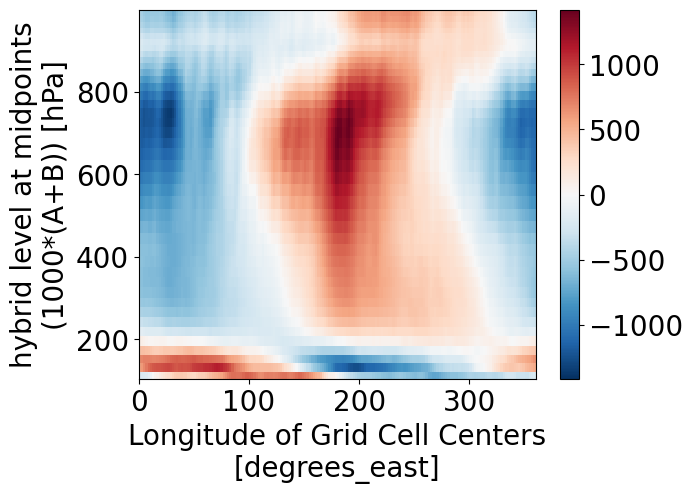

In [35]:
mse = mse_budget['mse']
mse_ano = mse - mse.mean(dim='lon')
mse_sft = mse_ano.copy()

for i in range(olrmin.size):
    mse_sft[i,:,:] = np.roll(mse_ano[i, :, :], shift=90-olrmin[i], axis=-1)

mse_sft.mean(dim='time').plot()

In [ ]:
mse_sft.mean(dim='time').plot()

In [ ]:
# def reorder_lon(u, lon0=181):

#     # left shift the dataset 
#     dim_lon = u.dims.index('lon')
#     lon0_index = np.where(u.lon.values == lon0)[0]
#     u_rolled_values = np.roll(u.values, -lon0_index, axis=dim_lon)

#     lon_rolled = np.roll(u['lon'].values, -lon0_index)

#     u_rolled = xr.DataArray(
#         data= u_rolled_values,
#         coords= u.coords,
#         dims= u.dims,
#     )

#     u_rolled['lon'] = lon_rolled

#     return u_rolled

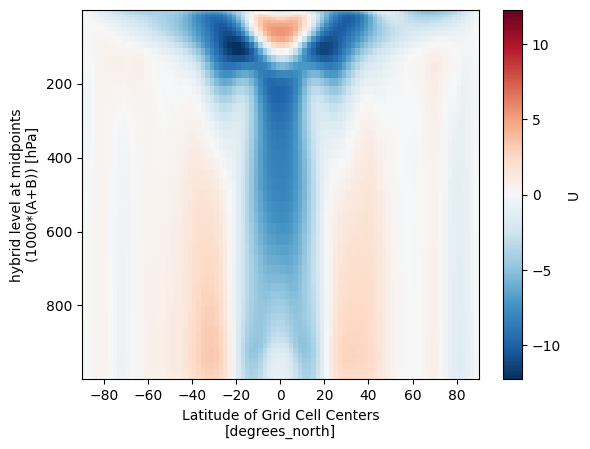

In [6]:
u = ds['U'].mean(dim=['time','lon']).load()
u.plot()
plt.gca().invert_yaxis()

Step 1: Meridionaly average OLR over 5S - 5N.

In [4]:
# read all files in the case directory
import glob
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds1 = xr.open_mfdataset(nc_files[-ndays:])
# olr = ds1['FLNT'].sel(lat=slice(-5,5)).resample(time='1D').mean().mean('lat').load()  # OLR[time, lon]

Step 2: Filter MJO-related OLR (k=1-3; T=20-100 day)

In [5]:
olr_flt = mjo.get_MJO_signal(olr)

NameError: name 'olr' is not defined

In [34]:
olr_flt['time'] = np.arange(olr_flt.time.size)

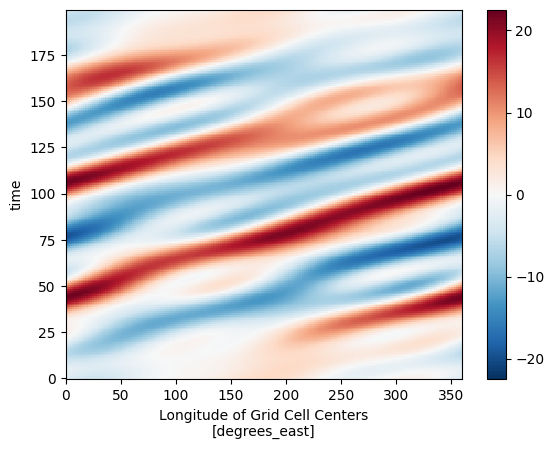

In [35]:
olr_flt.plot()

Step 3: version 1: choose OLR at 180 degree as the reference. 

In [36]:
olr_ref = olr_flt.sel(lon=181).copy()

Step 4: linear regression between a given field and the reference OLR. 
NOTE: this step can be improved by parallel computation.

In [37]:
olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()  # OLR[time, lat, lon]
olr_flt['time'] = olr.time.values

In [38]:
olr_coef = mjo.linear_regression(olr, olr_ref)  # inputs are field and time series.

In [39]:
olr_coef.shape

(30, 180, 2)

In [40]:
slope = olr_coef[:,:,0] 
const = olr_coef[:,:,1]

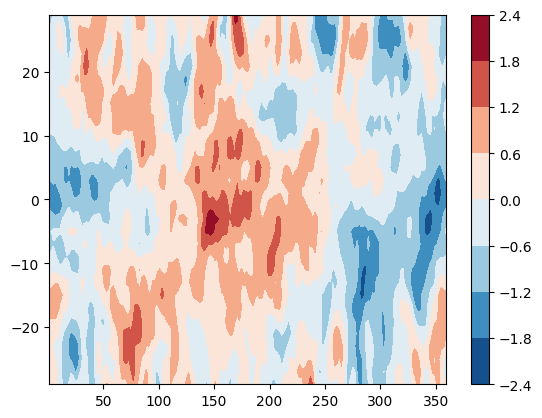

In [41]:
plt.contourf(olr.lon, olr.lat, slope, cmap='RdBu_r')
plt.colorbar()

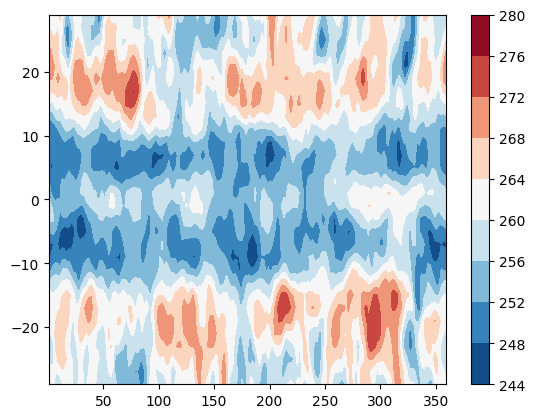

In [20]:
plt.contourf(olr.lon, olr.lat, const, cmap='RdBu_r')
plt.colorbar()

In [21]:
olr_reg = slope * olr_ref.std().values + const

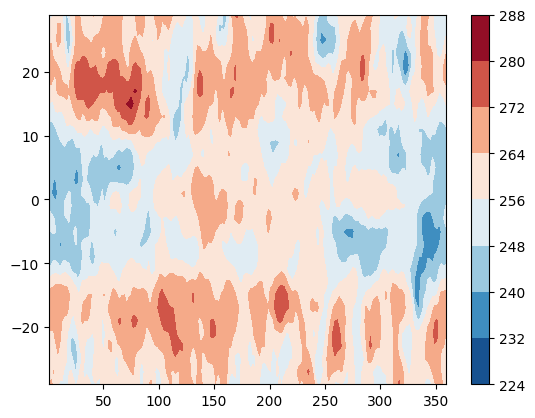

In [22]:
plt.contourf(olr.lon, olr.lat, olr_reg, cmap='RdBu_r')
plt.colorbar()

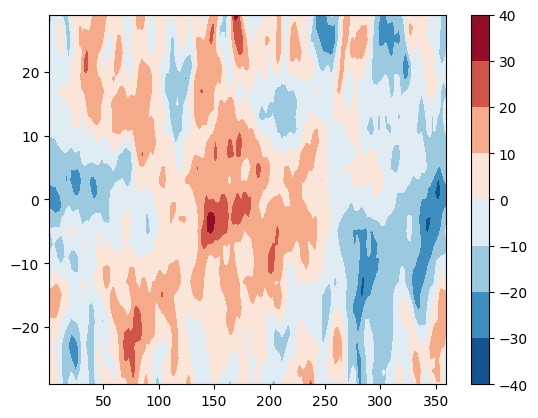

In [43]:
plt.contourf(olr.lon, olr.lat, 2 * slope * olr_ref.std().values, cmap='RdBu_r')
plt.colorbar()

Step 3 vesion 2: concatenate all longtidues to create a long time series

In [5]:
# get the reference long OLR time series
lat_lim = 45
olr_sel = ds1['FLNT'].sel(lat=slice(-5,5)).resample(time='1D').mean().load().mean('lat')  # OLR[time, lat, lon]

olr_flt = mjo.get_MJO_signal(olr_sel)
# olr_flt

In [1]:
# read all files in the case directory
import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])

coef = mjo.get_reg_local_MSE_budegt(ds, olr_flt, lat_lim=5, latmean=True)

NameError: name 'dirn' is not defined

In [ ]:
fn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/analysis/local_MSE_budget/coef_latavg5.json'
import os 
import json

os.makedirs(os.path.dirname(fn), exist_ok=True)
# Loop through the dictionary to convert ndarray to list
for key, value in coef.items():
    if isinstance(value, np.ndarray):
        coef[key] = value.tolist()

# Store to JSON file
with open(fn, 'w') as f:
    json.dump(coef, f)

# # Load from JSON file
# with open('coef.json', 'r') as f:
#     loaded_coef = json.load(f)
# for key, value in loaded_coef.items():
#     if isinstance(value, list):
#         loaded_coef[key] = np.array(value)

In [7]:
# read the raw field
raw_olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()  # OLR[time, lat, lon]
coef = mjo.global_linear_reg(raw_olr, olr_flt)

In [7]:
olr_flt.std().values

array(8.36740295)

Text(0.5, 1.0, 'OLR anomaly (W/m2)')

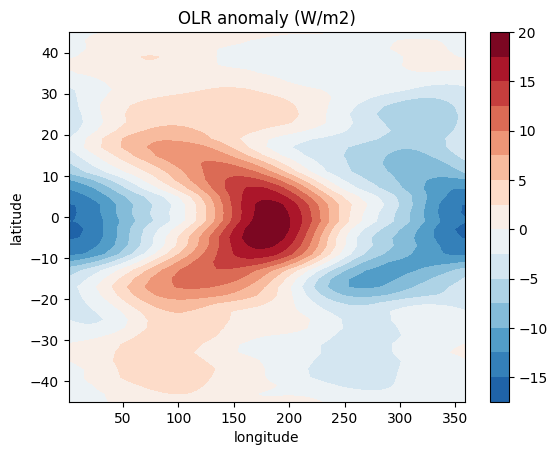

In [9]:
slope = coef[:,:,0] 
const = coef[:,:,1]
plt.contourf(raw_olr.lon, raw_olr.lat, - 2 * slope * olr_flt.std().values, cmap='RdBu_r', levels=15, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')  
plt.title('OLR anomaly (W/m2)')

Text(0.5, 1.0, 'OLR anomalies (W/m2)')

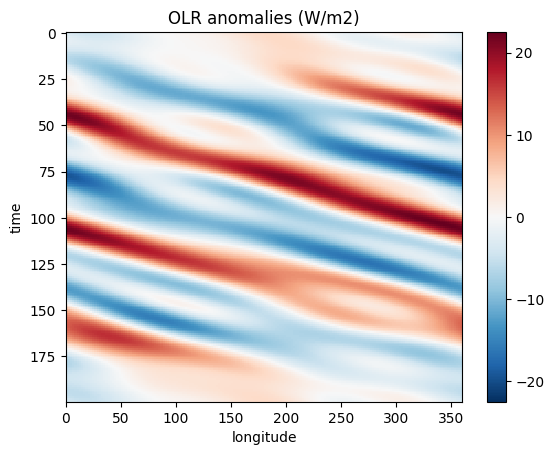

In [11]:
olr_flt['time'] = np.arange(olr_flt.time.size)
olr_flt.plot()
plt.gca().invert_yaxis()
# Optionally, add labels, titles, etc.
plt.xlabel('longitude')
plt.ylabel('time')
plt.title('OLR anomalies (W/m2)')

In [17]:
# read the raw field
raw_p = ds1['PRECT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean().load()  # OLR[time, lat, lon]
coef_p = mjo.global_linear_reg(raw_p * 8.64e7, olr_flt)

Text(0.5, 1.0, 'precipitation anomaly (mm/day)')

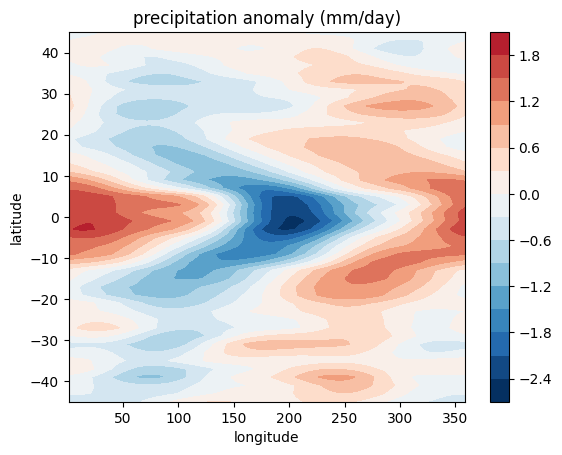

In [14]:
slope = coef[:,:,0] 
const = coef[:,:,1]
plt.contourf(raw_p.lon, raw_p.lat, 2 * slope * olr_flt.std().values, cmap='RdBu_r',levels=15, vmin=-2.5, vmax=2.5)
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')  
plt.title('precipitation anomaly (mm/day)')

In [15]:
avep = raw_p.sel(lat=slice(-5,5)).mean('lat') * 8.64e7
p_flt = mjo.get_MJO_signal(avep)

Text(0.5, 1.0, 'precipitation anomalies (mm/day)')

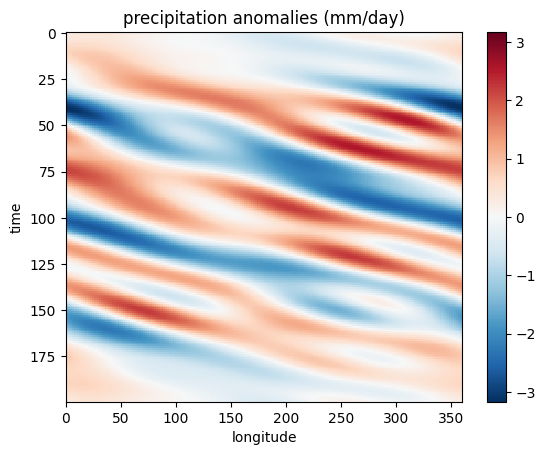

In [16]:
p_flt['time'] = np.arange(p_flt.time.size)
p_flt.plot()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('time')  
plt.title('precipitation anomalies (mm/day)')

In [8]:
# read all files in the case directory
import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])
ds 

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, time: 200, nbnd: 2, lev: 60, ilev: 61,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0009-10-29 00:00:00 ... 0010-05-16 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/52)
    lat_bnds      (time, lat, nbnd) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds      (time, lon, nbnd) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1, 90), meta=np.ndarray>
    area          (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    CLDICE        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 60, 90, 180), meta=np.ndarray>
    CLDLIQ        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 60, 90, 180), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login02
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

In [7]:
mse_budget = mjo.get_local_MSE_budget(ds)

NameError: name 'ds' is not defined

In [19]:
# read the raw field
geo_sel = ds['Z3'].sel(lat=slice(-lat_lim,lat_lim), lev=slice(180,220)).resample(time='1D').mean().load()  # OLR[time, lev, lat, lon]
raw_geo = geo_sel.mean('lev')  # [time, lat, lon]

coef_z = mjo.global_linear_reg(raw_geo, olr_flt)

Text(0.5, 1.0, 'Z200 anomaly (m)')

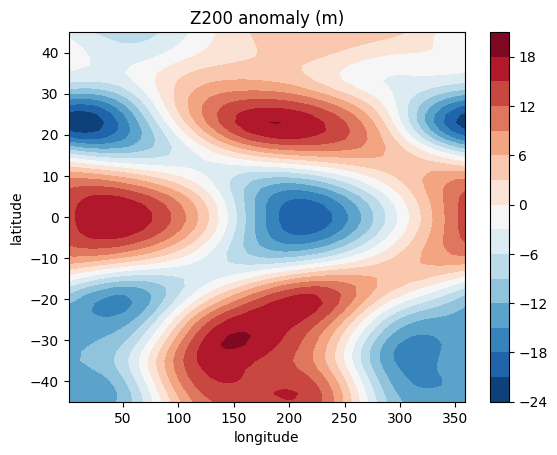

In [27]:
slope_z = coef_z[:,:,0] 
slope_p = coef_p[:,:,0]

plt.contourf(raw_geo.lon, raw_geo.lat, 2 * slope_z * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')  
plt.title('Z200 anomaly (m)')

Text(0.5, 1.0, 'surface precip (colors); Z200 anomaly (contours)')

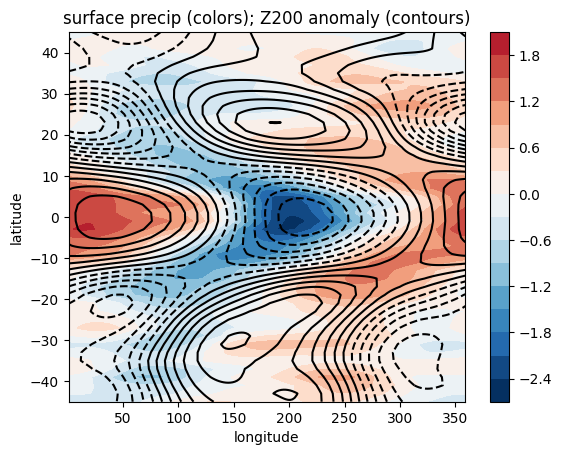

In [26]:
slope_z = coef_z[:,:,0] 
slope_p = coef_p[:,:,0]

plt.contourf(raw_geo.lon, raw_geo.lat, 2 * slope_p * olr_flt.std().values, cmap='RdBu_r',levels=15, vmin=-2.5, vmax=2.5)
plt.colorbar()

plt.contour(raw_geo.lon, raw_geo.lat, 2 * slope_z * olr_flt.std().values, colors='k', levels=15)
plt.xlabel('longitude')
plt.ylabel('latitude')  
plt.title('surface precip (colors); Z200 anomaly (contours)')

In [8]:
coef = mjo.get_reg_local_MSE_budegt(ds, olr_flt)

Text(0.5, 1.0, 'MSE tendency anomaly (J/kg/day)')

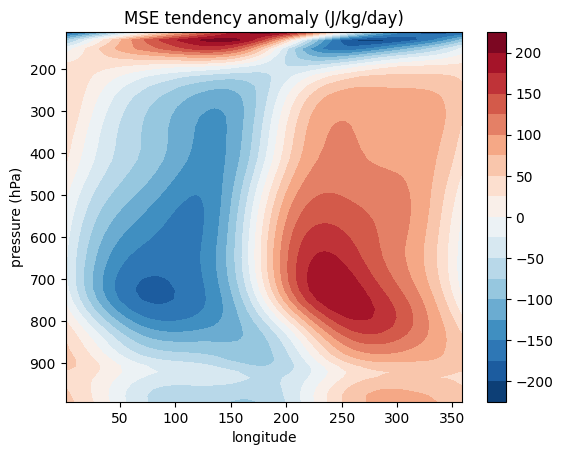

In [9]:
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, - 2 * coef['MSE_TEND'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=16)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE tendency anomaly (J/kg/day)')

Text(0.5, 1.0, 'MSE anomaly (J/kg)')

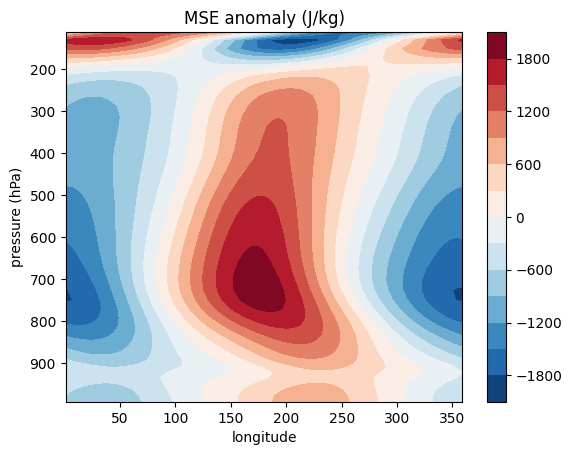

In [10]:
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, - 2 * coef['MSE'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE anomaly (J/kg)')

Text(0.5, 1.0, 'MSE production anomaly from CRM+PBL (J/kg/day)')

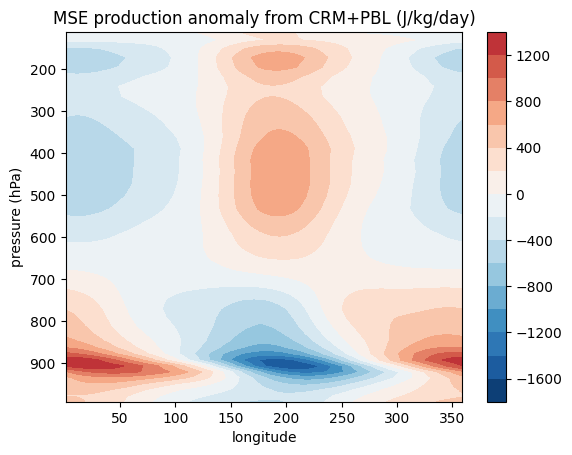

In [11]:
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, -2 * coef['MSE_CRMPBL'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=16, vmin=-1800, vmax=1800)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from CRM+PBL (J/kg/day)')

/tmp/ipykernel_430400/2946728991.py:1: UserWarning: The following kwargs were not used by contour: 'vamx'
  plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, - 2 * coef['MSE_QR'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=16,vmin=-450,vamx=450)


Text(0.5, 1.0, 'MSE production anomaly from QR (J/kg/day)')

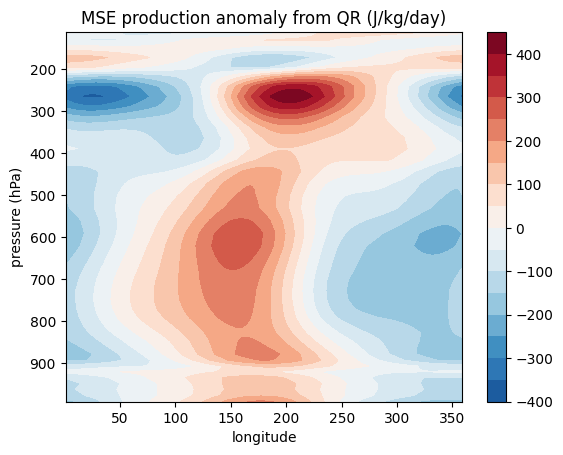

In [12]:
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, - 2 * coef['MSE_QR'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=16,vmin=-450,vamx=450)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from QR (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from DYN (J/kg/day)')

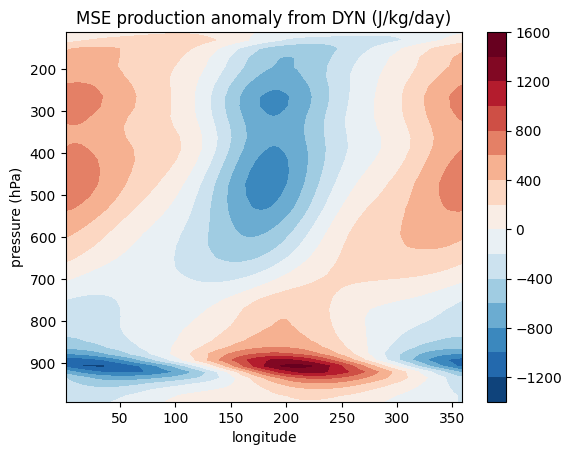

In [13]:
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, -2 * coef['MSE_DYN'][:,:,0] * olr_flt.std().values, cmap='RdBu_r',levels=16,vmin=-1400,vmax=1400)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from DYN (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from residual (J/kg/day)')

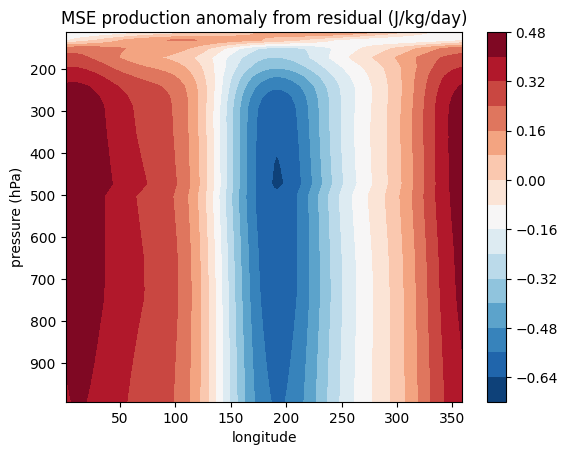

In [18]:
residual = coef['MSE_TEND'][:,:,0] - coef['MSE_CRMPBL'][:,:,0] - coef['MSE_QR'][:,:,0] - coef['MSE_DYN'][:,:,0]
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, - 2 * residual * olr_flt.std().values, cmap='RdBu_r',levels=16)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from residual (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from CRM+PBL+DYN (J/kg/day)')

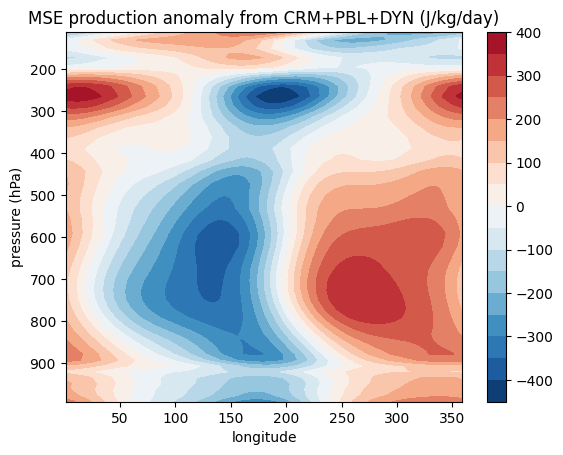

In [17]:
combo = coef['MSE_CRMPBL'][:,:,0] + coef['MSE_DYN'][:,:,0]
plt.contourf(ds.lon, ds.sel(lev=slice(100,None)).lev, -2 * combo * olr_flt.std().values, cmap='RdBu_r',levels=16,vmin=-450,vmax=450)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from CRM+PBL+DYN (J/kg/day)')

In [ ]:
# get local MSE tendency

dtmse_sel = mjo.get_local_MSE_tendency(ds, lat_lim=5).load()
raw_dtmse = dtmse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_dth = mjo.global_linear_reg(raw_dtmse, olr_flt)

slope_dth = coef_dth[:,:,0] 
const_dth = coef_dth[:,:,1] 


Text(0.5, 1.0, 'MSE tendency anomaly (J/kg/day)')

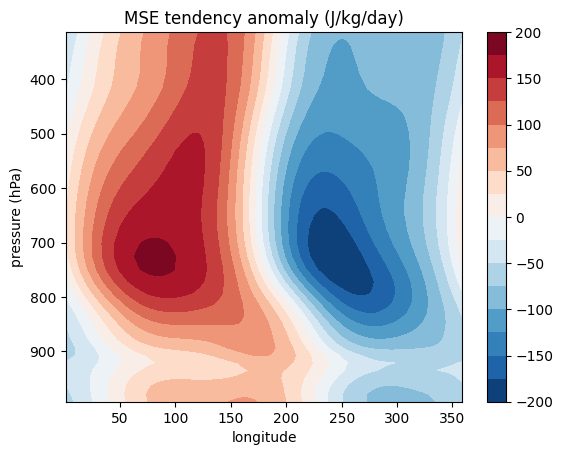

In [44]:

plt.contourf(raw_dtmse.lon, raw_dtmse.lev, 86400* 2 * slope_dth * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE tendency anomaly (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from CRM (J/kg/day)')

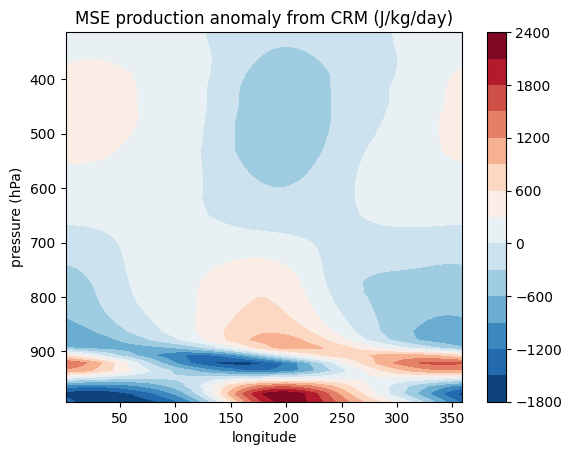

In [46]:
# get local MSE tendency

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_CRM',lat_lim=5).load() + mjo.get_local_MSE_source(ds,'DQLV_CRM',lat_lim=5).load()

raw_dtmse = dtmse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_dth = mjo.global_linear_reg(raw_dtmse, olr_flt)

slope_dth = coef_dth[:,:,0] 
const_dth = coef_dth[:,:,1] 

plt.contourf(raw_dtmse.lon, raw_dtmse.lev, 86400* 2 * slope_dth * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from CRM (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from QR (J/kg/day)')

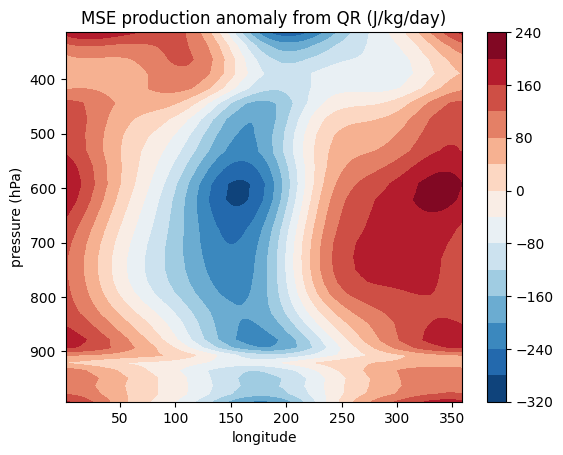

In [47]:
# get local MSE tendency

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_QRS',lat_lim=5).load() + mjo.get_local_MSE_source(ds,'DDSE_QRL',lat_lim=5).load()

raw_dtmse = dtmse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_dth = mjo.global_linear_reg(raw_dtmse, olr_flt)

slope_dth = coef_dth[:,:,0] 
const_dth = coef_dth[:,:,1] 

plt.contourf(raw_dtmse.lon, raw_dtmse.lev, 86400* 2 * slope_dth * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from QR (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from DYN (J/kg/day)')

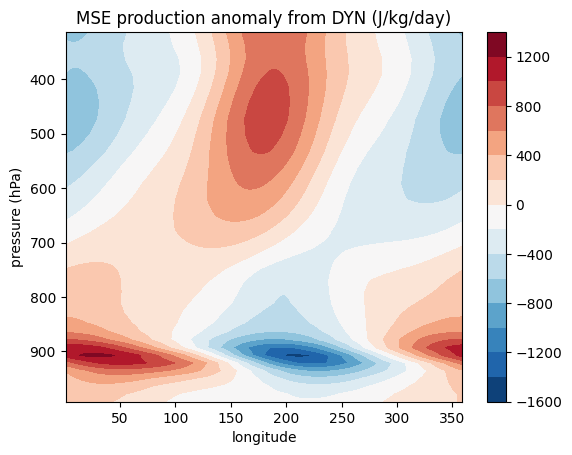

In [48]:
# get local MSE tendency

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_DYN',lat_lim=5).load() + mjo.get_local_MSE_source(ds,'DQLV_DYN',lat_lim=5).load()

raw_dtmse = dtmse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_dth = mjo.global_linear_reg(raw_dtmse, olr_flt)

slope_dth = coef_dth[:,:,0] 
const_dth = coef_dth[:,:,1] 

plt.contourf(raw_dtmse.lon, raw_dtmse.lev, 86400* 2 * slope_dth * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from DYN (J/kg/day)')

Text(0.5, 1.0, 'MSE production anomaly from PBL (J/kg/day)')

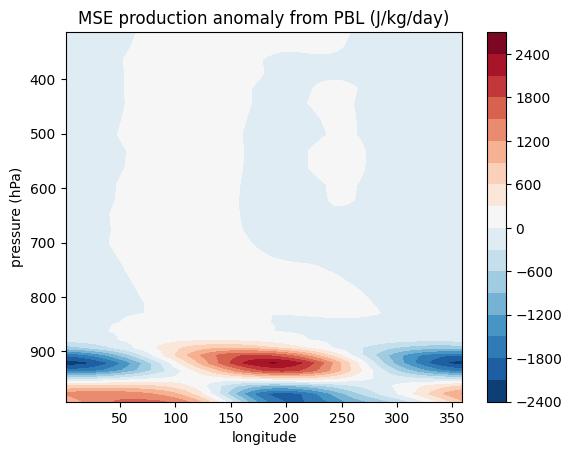

In [49]:
# get local MSE tendency

dtmse_sel = mjo.get_local_MSE_source(ds,'DDSE_PBL',lat_lim=5).load() + mjo.get_local_MSE_source(ds,'DQLV_PBL',lat_lim=5).load()

raw_dtmse = dtmse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_dth = mjo.global_linear_reg(raw_dtmse, olr_flt)

slope_dth = coef_dth[:,:,0] 
const_dth = coef_dth[:,:,1] 

plt.contourf(raw_dtmse.lon, raw_dtmse.lev, 86400* 2 * slope_dth * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE production anomaly from PBL (J/kg/day)')

In [32]:
# read the raw field
mse_sel = mjo.get_local_MSE(ds, lat_lim=5).load()
raw_mse = mse_sel.sel(lev=slice(300,None)).mean('lat')  # [time, lev, lon]

coef_h = mjo.global_linear_reg(raw_mse, olr_flt)

Text(0.5, 1.0, 'MSE anomaly (J/kg)')

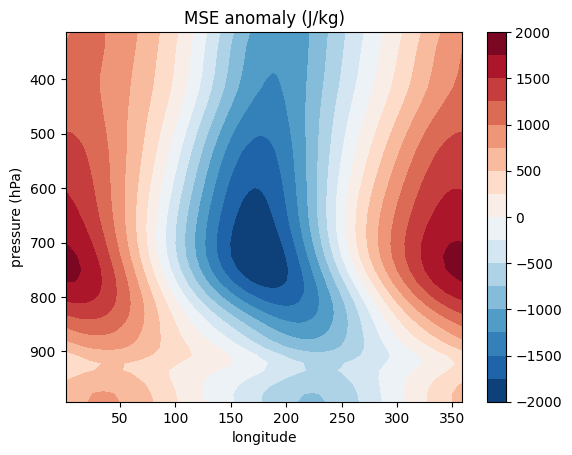

In [33]:
slope_h = coef_h[:,:,0] 
const_h = coef_h[:,:,1] 

plt.contourf(raw_mse.lon, raw_mse.lev, 2 * slope_h * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE anomaly (J/kg)')

Text(0.5, 1.0, 'MSE regressed (J/kg)')

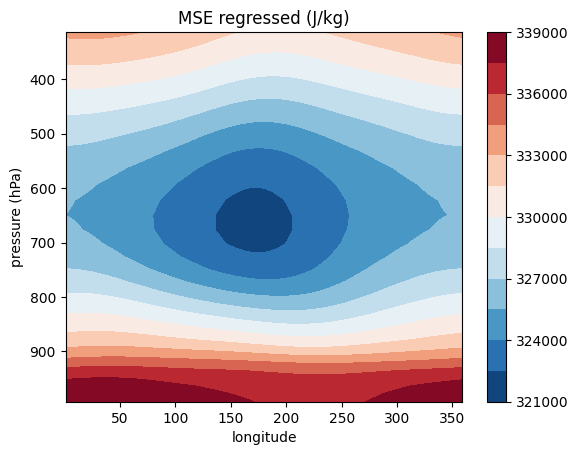

In [36]:
plt.contourf(raw_mse.lon, raw_mse.lev, const_h+2 * slope_h * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('pressure (hPa)')  
plt.title('MSE regressed (J/kg)')

In [37]:
# read the raw field
intmse_sel = mjo.get_integrated_MSE(ds, lat_lim=lat_lim).load()
coef_ih = mjo.global_linear_reg(intmse_sel, olr_flt)

Text(0.5, 1.0, 'integrated MSE anomaly (J/m2)')

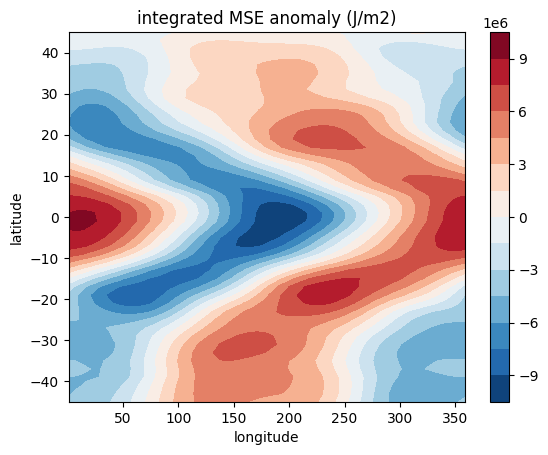

In [38]:
slope_ih = coef_ih[:,:,0] 
const_ih = coef_ih[:,:,1] 

plt.contourf(intmse_sel.lon, intmse_sel.lat, 2 * slope_ih * olr_flt.std().values, cmap='RdBu_r',levels=15)
plt.colorbar()
# plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('integrated MSE anomaly (J/m2)')

Text(0.5, 1.0, 'integrated MSE anomalies (J/m2)')

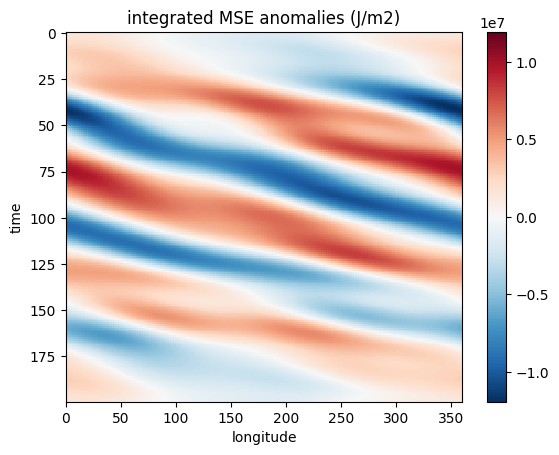

In [40]:
ih_hv = intmse_sel.sel(lat=slice(-5,5)).mean('lat') # [time, lat, lon]
ih_flt = mjo.get_MJO_signal(ih_hv)
ih_flt['time'] = np.arange(ih_flt.time.size)
ih_flt.plot()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('time')
plt.title('integrated MSE anomalies (J/m2)')

Text(0.5, 1.0, 'integrated MSE anomalies (J/m2)')

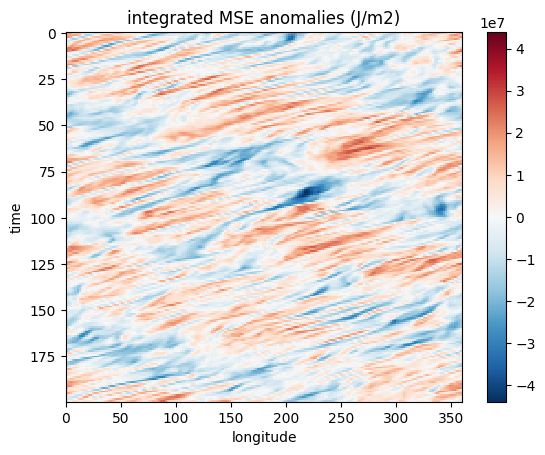

In [42]:
ih_hv['time'] = np.arange(ih_hv.time.size)
(ih_hv - ih_hv.mean('time')).plot()
plt.gca().invert_yaxis()
plt.xlabel('longitude')
plt.ylabel('time')
plt.title('integrated MSE anomalies (J/m2)')

In [ ]:
intmse_sel = mjo.get_integrated_MSE(ds, lat_lim=lat_lim).load()
coef_ih = mjo.global_linear_reg(intmse_sel, olr_flt)

In [29]:
x0 = xr.DataArray(
    data=np.arange(olr.time.size),
    dims=['time'],
    coords={'time': olr.time.values},
)

In [31]:
y = xr.DataArray(
    data=np.zeros(olr.shape),
    dims=['time', 'lat', 'lon'],
    coords={'time': olr.time.values, 'lat': olr.lat.values, 'lon': olr.lon.values},
)   + 2 * x0 + 1


In [34]:
cof = mjo.linear_regression(y,x0)

In [3]:

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])


In [15]:
# Step 1: filter the meridional-averaged OLR 
olr_flt = mjo.get_MJO_signal(olr)


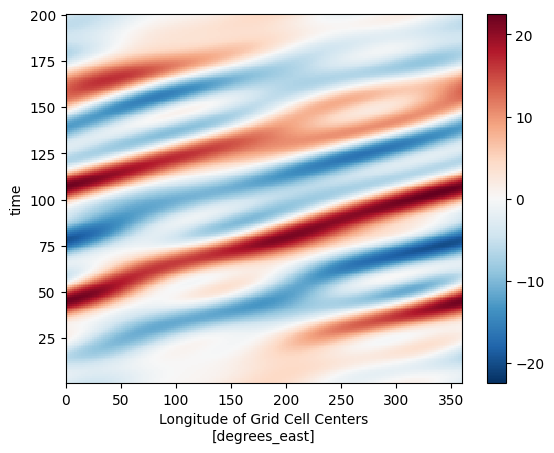

In [19]:
olr_flt['time'] = np.arange(1, len(olr_flt.time)+1)
olr_flt.plot()

In [24]:
olr_re = xr.DataArray(
    data=np.reshape(olr_flt.values, (len(olr_flt.time), 1, len(olr_flt.lon))),
    dims=['time','lat','lon'],
    coords={
        'time': olr.time,
        'lat': [0],
        'lon': olr_flt.lon,
    },
)
olr_re

<xarray.DataArray (time: 200, lat: 1, lon: 180)>
array([[[-3.38722405, -3.59815796, -3.79477858, ..., -2.68488972,
         -2.92884006, -3.16355244]],

       [[-2.83477754, -3.04561405, -3.2454874 , ..., -2.15364462,
         -2.38699125, -2.61464874]],

       [[-2.37907166, -2.5771232 , -2.76755012, ..., -1.75613451,
         -1.96682511, -2.17506247]],

       ...,

       [[-5.04921346, -5.19124113, -5.31208211, ..., -4.50550943,
         -4.70523079, -4.88686475]],

       [[-4.550623  , -4.72513742, -4.8799783 , ..., -3.92130834,
         -4.14732387, -4.35758212]],

       [[-3.9787656 , -4.17711766, -4.35815428, ..., -3.29446457,
         -3.53583442, -3.7644916 ]]])
Coordinates:
  * time     (time) object 0009-10-29 00:00:00 ... 0010-05-16 00:00:00
  * lat      (lat) int64 0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0

In [25]:
smooth_sym, smooth_asym, background, sym_norm, asym_norm, sym_normp_sym, asym_normp_asym = mjo.wk_analysis(olr_re)

size of taper:  (96,)
(3, 179, 47)
(179, 47)


In [ ]:
mjo.wk_plot_sym()

In [6]:
local_mse = mjo.get_local_MSE(ds, lat_lim=30)
local_mse_mjo, p = mjo.MJO_regression_4D(local_mse, olr, ds)

In [7]:
local_QRL = mjo.get_local_MSE_source(ds, 'DDSE_QRL', lat_lim=30)  #[time, lev, lat, lon]
local_QRL_mjo, p_qrl = mjo.MJO_regression_4D(local_QRL, olr, ds)

In [8]:
RAD = mjo.get_LMSE_budget_term(local_mse_mjo, local_QRL_mjo)

<xarray.DataArray ()>
array(30480.2786851)

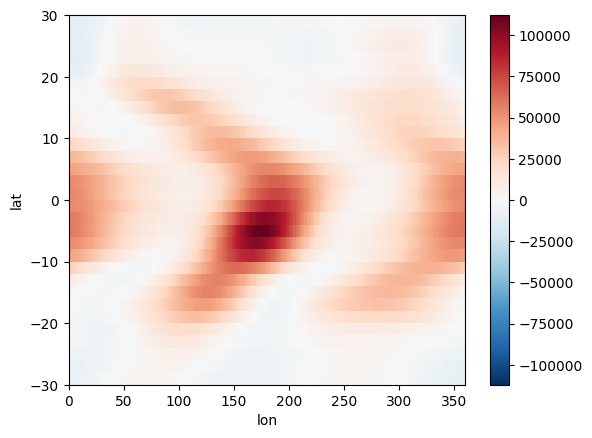

In [32]:
RAD.plot()
RAD.sel(lat=slice(-10,10)).mean()

In [25]:
local_DYN = mjo.get_local_MSE_source(ds, 'DDSE_DYN', lat_lim=30)  #[time, lev, lat, lon]
local_DYN_mjo, p_DYN = mjo.MJO_regression_4D(local_DYN, olr, ds)

<xarray.DataArray ()>
array(-137209.90758237)

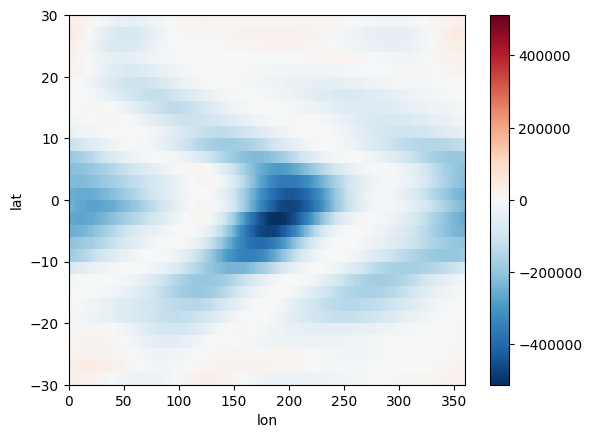

In [31]:
DYN = mjo.get_LMSE_budget_term(local_mse_mjo, local_DYN_mjo)
DYN.plot()
DYN.sel(lat=slice(-10,10)).mean()

In [33]:
local_CRM = mjo.get_local_MSE_source(ds, 'DDSE_CRM', lat_lim=10)  #[time, lev, lat, lon]
local_CRM_mjo, p_CRM = mjo.MJO_regression_4D(local_CRM, olr, ds)

<xarray.DataArray ()>
array(94152.90995561)

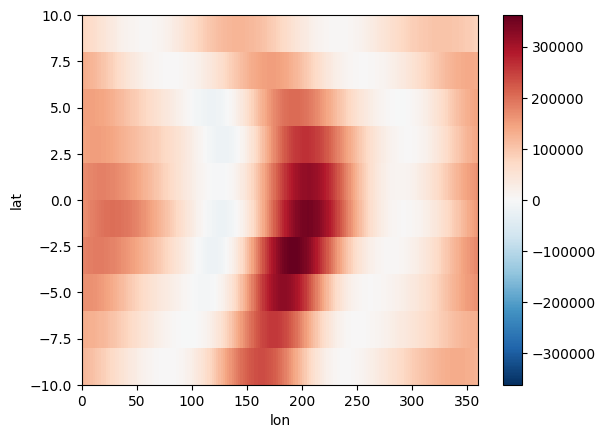

In [34]:
CRM = mjo.get_LMSE_budget_term(local_mse_mjo, local_CRM_mjo)
CRM.plot()
CRM.sel(lat=slice(-10,10)).mean()

In [35]:
# Convert these DataArrays to a Dataset
ds = xr.Dataset({
    'CRM': CRM,
    'DYN': DYN,
    'RAD': RAD,
})

# Save the dataset to a NetCDF file
ds.to_netcdf('output_filename.nc')

<xarray.DataArray ()>
array(261.10077805)

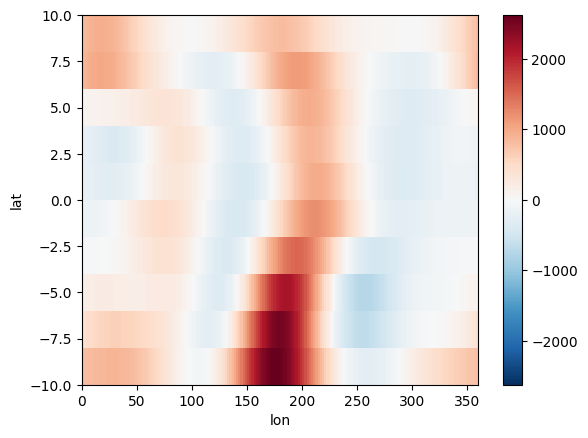

In [38]:
local_PBL = mjo.get_local_MSE_source(ds, 'DDSE_PBL', lat_lim=10)  #[time, lev, lat, lon]
local_PBL_mjo, p_PBL = mjo.MJO_regression_4D(local_PBL, olr, ds)
PBL = mjo.get_LMSE_budget_term(local_mse_mjo, local_PBL_mjo)
PBL.plot()
PBL.sel(lat=slice(-10,10)).mean()

<xarray.DataArray ()>
array(-101564.92799223)

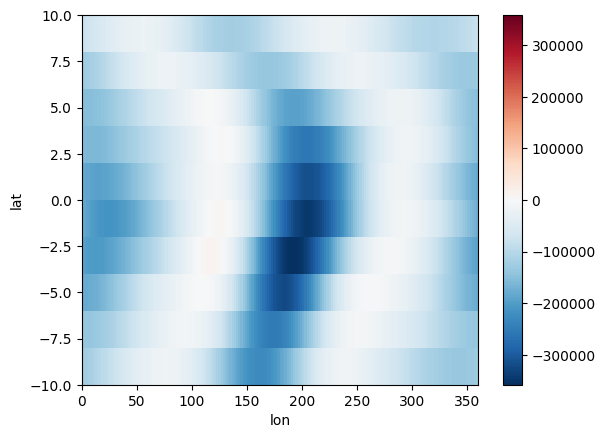

In [39]:
local_DQLV_CRM = mjo.get_local_MSE_source(ds, 'DQLV_CRM', lat_lim=10)  #[time, lev, lat, lon]
local_DQLV_CRM_mjo, p_DQLV_CRM = mjo.MJO_regression_4D(local_DQLV_CRM, olr, ds)
DQLV_CRM = mjo.get_LMSE_budget_term(local_mse_mjo, local_DQLV_CRM_mjo)
DQLV_CRM.plot()
DQLV_CRM.sel(lat=slice(-10,10)).mean()

<xarray.DataArray ()>
array(-2887.2475907)

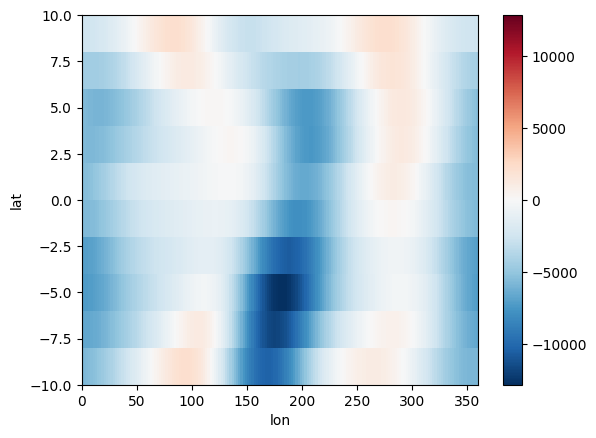

In [40]:
local_DDSE_QRS = mjo.get_local_MSE_source(ds, 'DDSE_QRS', lat_lim=10)  #[time, lev, lat, lon]
local_DDSE_QRS_mjo, p_DDSE_QRS = mjo.MJO_regression_4D(local_DDSE_QRS, olr, ds)
DDSE_QRS = mjo.get_LMSE_budget_term(local_mse_mjo, local_DDSE_QRS_mjo)
DDSE_QRS.plot()
DDSE_QRS.sel(lat=slice(-10,10)).mean()

<xarray.DataArray ()>
array(101302.70733708)

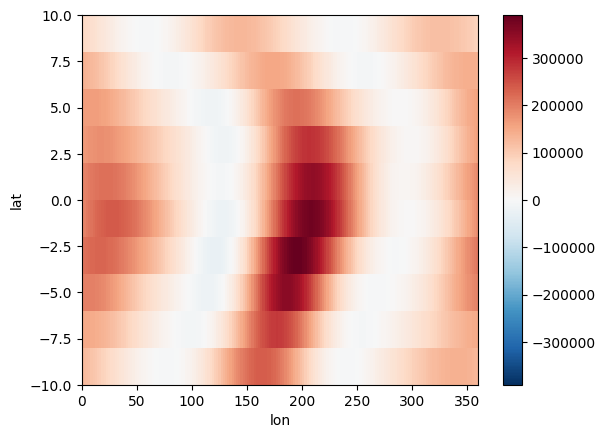

In [41]:
local_DQLV_DYN = mjo.get_local_MSE_source(ds, 'DQLV_DYN', lat_lim=10)  #[time, lev, lat, lon]
local_DQLV_DYN_mjo, p_DQLV_DYN = mjo.MJO_regression_4D(local_DQLV_DYN, olr, ds)
DQLV_DYN = mjo.get_LMSE_budget_term(local_mse_mjo, local_DQLV_DYN_mjo)
DQLV_DYN.plot()
DQLV_DYN.sel(lat=slice(-10,10)).mean()

<xarray.DataArray ()>
array(4107.7444705)

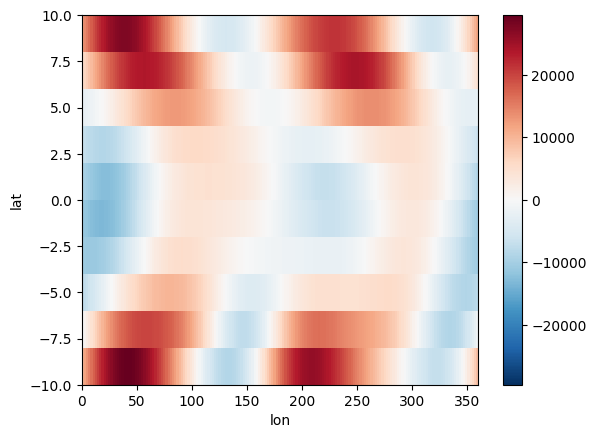

In [42]:
local_DQLV_PBL = mjo.get_local_MSE_source(ds, 'DQLV_PBL', lat_lim=10)  #[time, lev, lat, lon]
local_DQLV_PBL_mjo, p_DQLV_PBL = mjo.MJO_regression_4D(local_DQLV_PBL, olr, ds)
DQLV_PBL = mjo.get_LMSE_budget_term(local_mse_mjo, local_DQLV_PBL_mjo)
DQLV_PBL.plot()
DQLV_PBL.sel(lat=slice(-10,10)).mean()

<xarray.DataArray ()>
array(-1120.26493391)

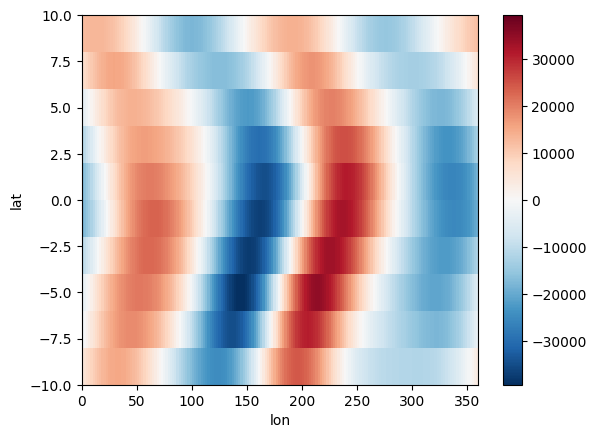

In [43]:
local_tend = mjo.get_local_MSE_tendency(ds, lat_lim=10)  #[time, lev, lat, lon]
local_tend_mjo, p_tend = mjo.MJO_regression_4D(local_tend, olr, ds)
tend = mjo.get_LMSE_budget_term(local_mse_mjo, local_tend_mjo)
tend.plot()
tend.sel(lat=slice(-10,10)).mean()

In [44]:
# Convert these DataArrays to a Dataset
ds0 = xr.Dataset({
    'DDSE_CRM': CRM,
    'DDSE_DYN': DYN,
    'DDSE_QRL': RAD,
    'DDSE_QRS': DDSE_QRS,
    'DDSE_PBL': PBL,
    'DQLV_CRM': DQLV_CRM,
    'DQLV_PBL': DQLV_PBL,
    'DQLV_DYN': DQLV_DYN,
    'tend': tend,
})

# Save the dataset to a NetCDF file
ds0.to_netcdf('LMSE_budget.nc')

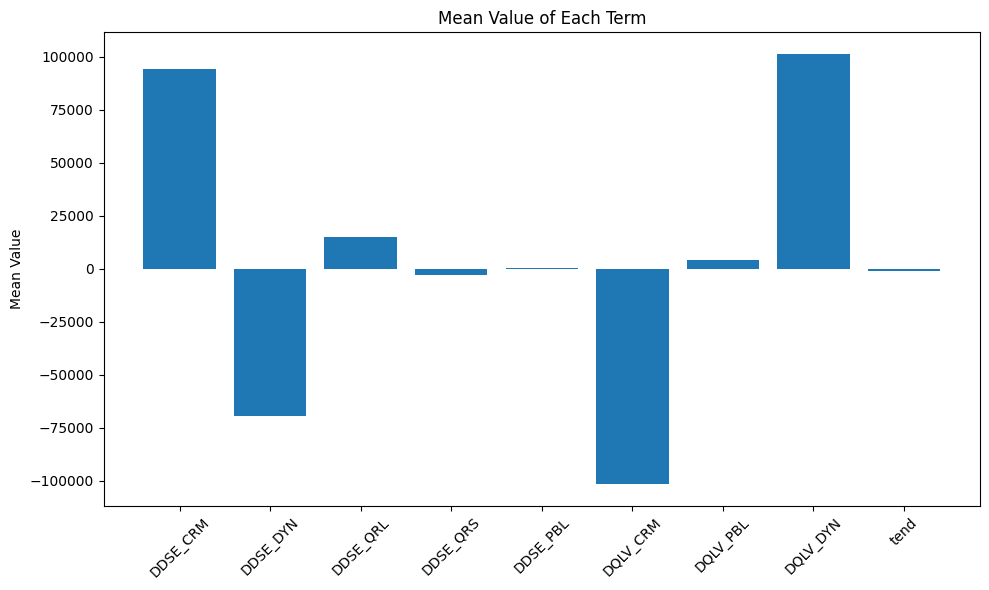

In [45]:
# Compute the mean for each term
means = ds0.mean()  # assuming the dimension over which you want to average is 'time'

# Plotting
labels = list(means.variables)
values = [means[var].values for var in labels]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, values)
ax.set_ylabel('Mean Value')
ax.set_title('Mean Value of Each Term')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [46]:
# Convert these DataArrays to a Dataset
ds2 = xr.Dataset({
    'local_DDSE_CRM': local_CRM_mjo,
    'local_DDSE_DYN': local_DYN_mjo,
    'local_DDSE_QRL': local_QRL_mjo,
    'local_DDSE_QRS': local_DDSE_QRS_mjo,
    'local_DDSE_PBL': local_PBL_mjo,
    'local_DQLV_CRM': local_DQLV_CRM_mjo,
    'local_DQLV_PBL': local_DQLV_PBL_mjo,
    'local_DQLV_DYN': local_DQLV_DYN_mjo,
    'local_tend': local_tend_mjo,
    'local_mse': local_mse_mjo,
})

# Save the dataset to a NetCDF file
ds2.to_netcdf('/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/analysis/local_variance_budget.nc')

In [47]:
CRM = mjo.get_GMSE_budget_term(local_mse_mjo, local_CRM_mjo)
DYN = mjo.get_GMSE_budget_term(local_mse_mjo, local_DYN_mjo)
QRL = mjo.get_GMSE_budget_term(local_mse_mjo, local_QRL_mjo)
DDSE_QRS = mjo.get_GMSE_budget_term(local_mse_mjo, local_DDSE_QRS_mjo)
PBL = mjo.get_GMSE_budget_term(local_mse_mjo, local_PBL_mjo)
DQLV_CRM = mjo.get_GMSE_budget_term(local_mse_mjo, local_DQLV_CRM_mjo)
DQLV_PBL = mjo.get_GMSE_budget_term(local_mse_mjo, local_DQLV_PBL_mjo)
DQLV_DYN = mjo.get_GMSE_budget_term(local_mse_mjo, local_DQLV_DYN_mjo)
tend = mjo.get_GMSE_budget_term(local_mse_mjo, local_tend_mjo)
mse = mjo.get_GMSE_budget_term(local_mse_mjo, local_mse_mjo)


In [50]:
# Convert these DataArrays to a Dataset
ds3 = xr.Dataset({
    'DDSE_CRM': CRM,
    'DDSE_DYN': DYN,
    'DDSE_QRL': RAD,
    'DDSE_QRS': DDSE_QRS,
    'DDSE_PBL': PBL,
    'DQLV_CRM': DQLV_CRM,
    'DQLV_PBL': DQLV_PBL,
    'DQLV_DYN': DQLV_DYN,
    'tend': tend,
})

# Save the dataset to a NetCDF file
ds3.to_netcdf('GMSE_budget.nc')

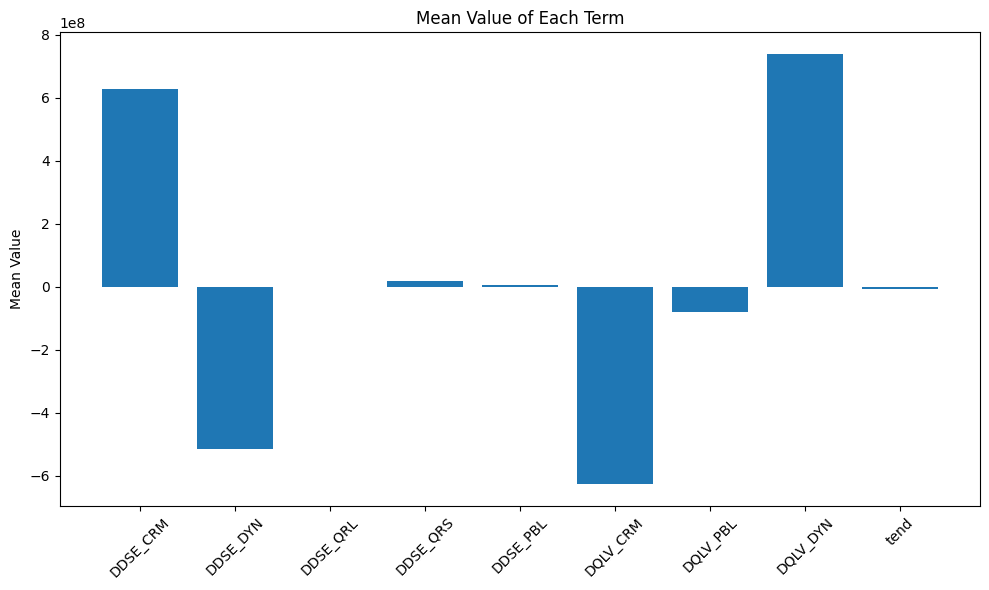

In [51]:
# Compute the mean for each term
means = ds3.mean()  # assuming the dimension over which you want to average is 'time'

# Plotting
labels = list(means.variables)
values = [means[var].values for var in labels]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, values)
ax.set_ylabel('Mean Value')
ax.set_title('Mean Value of Each Term')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
p = local_DYN_mjo['lev'].values
dp = np.zeros(len(p))

dp[1:] = p[1:] - p[0:-1]
dp[0] = dp[1]  # hPa

g = 9.8

int_DYN = (local_DYN_mjo * np.reshape(dp, (len(dp), 1, 1)) / g * 100).sum(dim='lev').squeeze()
int_DYN.plot()

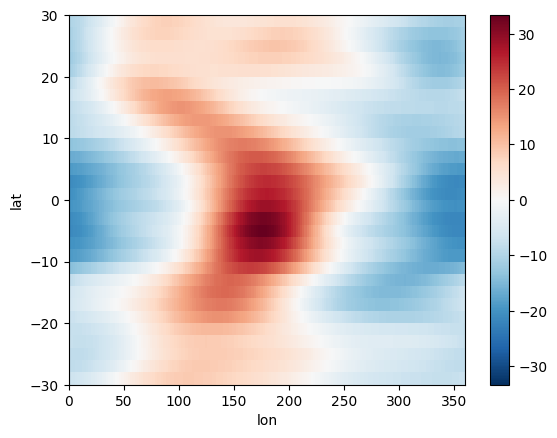

In [15]:
p = local_QRL_mjo['lev'].values
dp = np.zeros(len(p))

dp[1:] = p[1:] - p[0:-1]
dp[0] = dp[1]  # hPa

g = 9.8

int_RAD = (local_QRL_mjo * np.reshape(dp, (len(dp), 1, 1)) / g * 100).sum(dim='lev').squeeze()
int_RAD.plot()


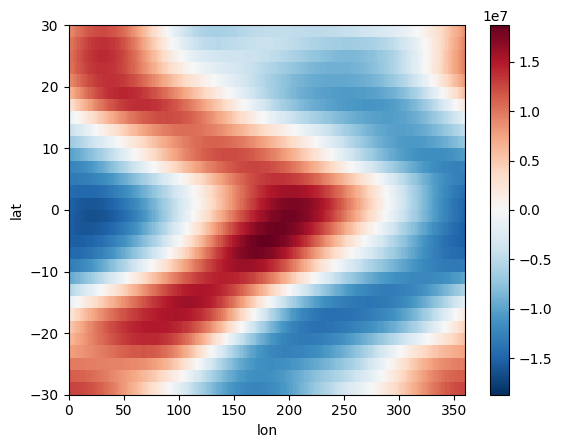

In [16]:
p = local_mse_mjo['lev'].values
dp = np.zeros(len(p))

dp[1:] = p[1:] - p[0:-1]
dp[0] = dp[1]  # hPa

g = 9.8

int_mse = (local_mse_mjo * np.reshape(dp, (len(dp), 1, 1)) / g * 100).sum(dim='lev').squeeze()
int_mse.plot()

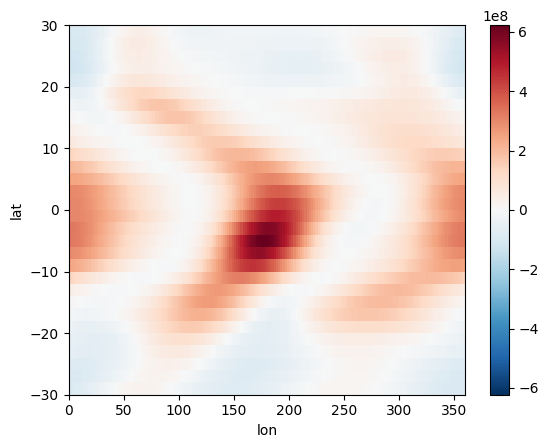

In [17]:
(int_mse * int_RAD).plot()

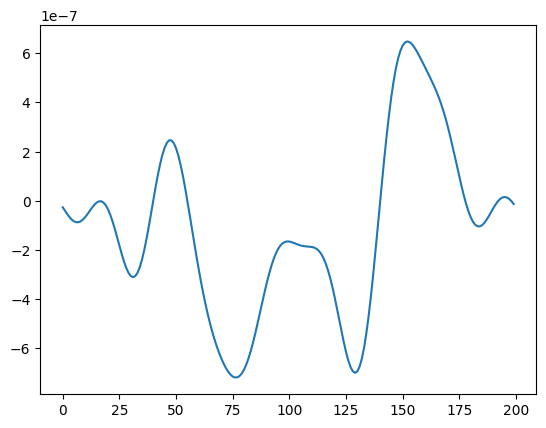

In [5]:
# get MJO-filtered signals
local_QRL = mjo.get_local_MSE_source(ds, 'DDSE_QRL', lat_lim=30)
local_QRL_flt = mjo.get_MJO_signal_3D(local_QRL)
LMSE_ano2_QRL = mjo.get_LMSE_ano2_term(local_mse_flt, local_QRL_flt, ds)
tmp = LMSE_ano2_QRL.mean(dim=['lat','lon'])
plt.plot(np.arange(len(tmp)), tmp*86400)

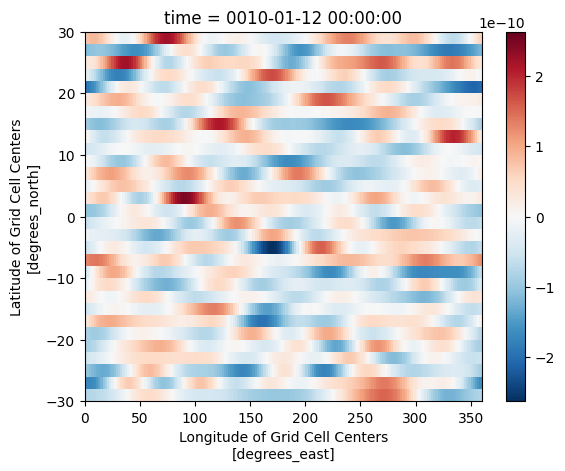

In [6]:
LMSE_ano2_QRL[75,:,:].plot()

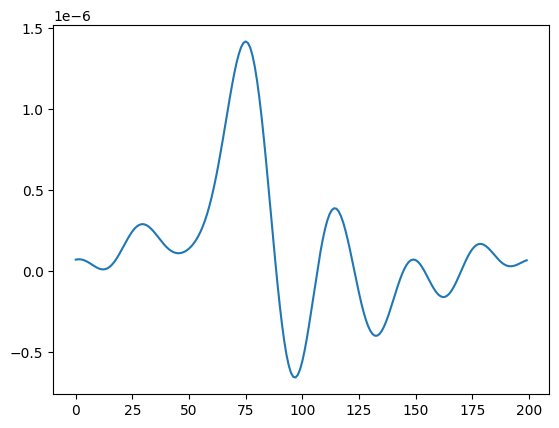

In [7]:
# get MJO-filtered signals
local_tend = mjo.get_local_MSE_tendency(ds, lat_lim=30)
local_tend_flt = mjo.get_MJO_signal_3D(local_tend)
LMSE_ano2_tend = mjo.get_LMSE_ano2_term(local_mse_flt, local_tend_flt, ds)
tmp = LMSE_ano2_tend.mean(dim=['lat','lon'])
plt.plot(np.arange(len(tmp)), tmp*86400)

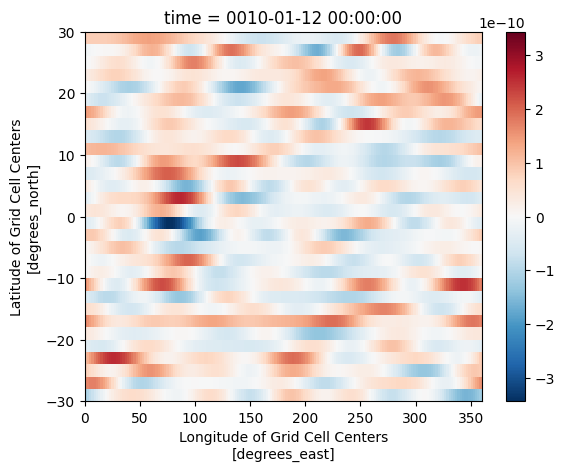

In [9]:
LMSE_ano2_tend[75,:,:].plot()

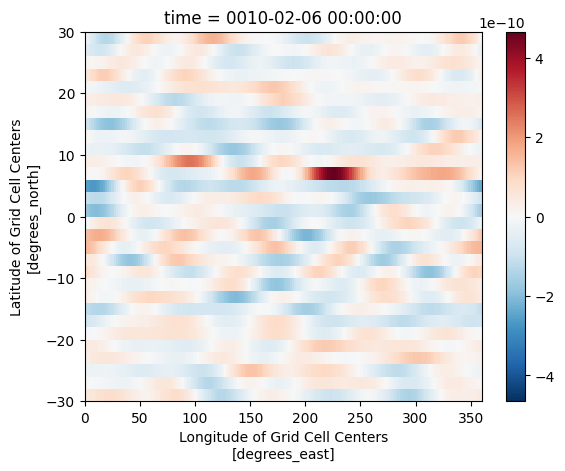

In [10]:
LMSE_ano2_tend[100,:,:].plot()

: 

: 

In [7]:
mse_tend = mjo.get_integrated_MSE_tendency(ds)

coef = mjo.MJO_regression(mse_tend, olr)

Text(0.5, 1.0, 'MJO-regressed VI-MSE tendency')

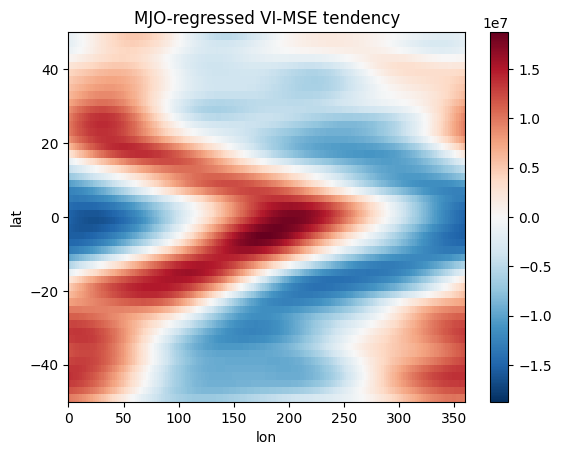

In [13]:
fig, ax = plt.subplots()
(-coef * 40).plot(ax=ax)
ax.set_title('MJO-regressed VI-MSE tendency')

In [11]:
mse = mjo.get_integrated_MSE(ds)

coef = mjo.MJO_regression(mse, olr)

Text(0.5, 1.0, 'MJO-regressed VI-MSE')

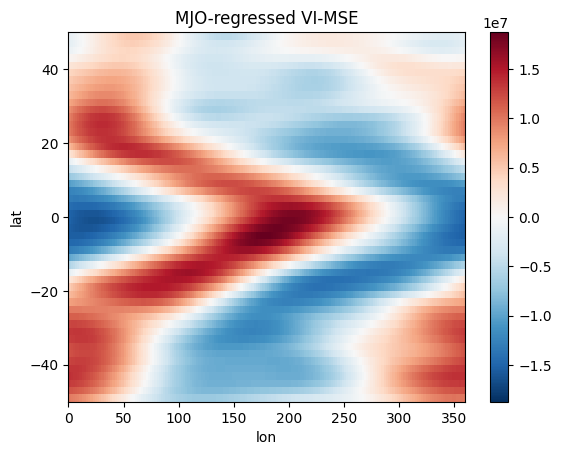

In [14]:
fig, ax = plt.subplots()
(-coef * 40).plot(ax=ax)
ax.set_title('MJO-regressed VI-MSE')

Calculate the MSE.

In [ ]:
TOT = CRM + (QRL + QRS) + DYN + PBL 

In [2]:
fn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/control/3D/E3SM.GNUGPU.ne30pg2.F-MMFXX-RCEROT.BVT.RADNX_1.04.eam.h2.0001-01-01-00000.nc_regridded.nc'
ds = xr.open_dataset(fn)
ds 

<xarray.Dataset>
Dimensions:       (lat: 90, lon: 180, nbnd: 2, time: 1, lev: 60, ilev: 61,
                   lwband: 16, swband: 14)
Coordinates:
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon           (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * ilev          (ilev) float64 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev           (lev) float64 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * lwband        (lwband) float64 130.0 375.0 565.0 ... 2.535e+03 2.965e+03
  * swband        (swband) float64 2.925e+03 3.625e+03 ... 4.4e+04 1.71e+03
  * time          (time) object 0001-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/52)
    lat_bnds      (lat, nbnd) float64 ...
    lon_bnds      (lon, nbnd) float64 ...
    gw            (lat) float64 ...
    area          (lat, lon) float64 ...
    CLDICE        (time, lev, lat, lon) float32 ...
    CLDLIQ        (time, lev, lat, lon) float32 ...
    ...            ...
    nsbase        int32 ...
    nscur         (time) int32 ...
    nsteph        (time) int32 ...
    sol_tsi       (time) float64 ...
    time_bnds     (time, nbnd) object ...
    time_written  (time) |S8 ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 75e954ad3f
    product:                   model-output
    ...                        ...
    remap_hostname:            login02
    remap_version:             5.1.4
    NCO:                       netCDF Operators version 5.1.4 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/l/linyaoly/MJO_E3SM/remap/map_ne...
    input_file:                /global/cfs/cdirs/m3312/whannah/2022-RCEROT/E3...

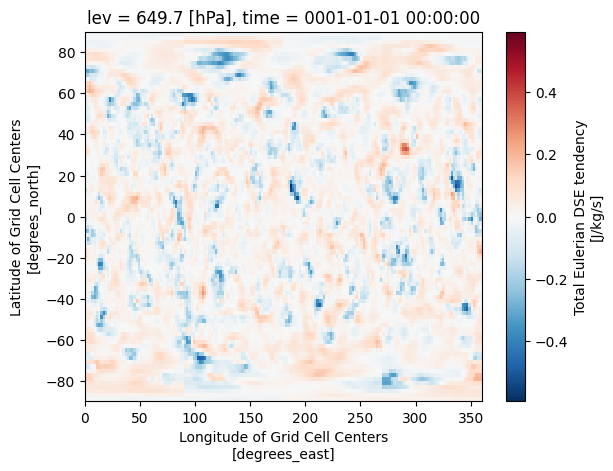

In [8]:
ds['DDSE_TOT'][0,-20,:,:].plot()

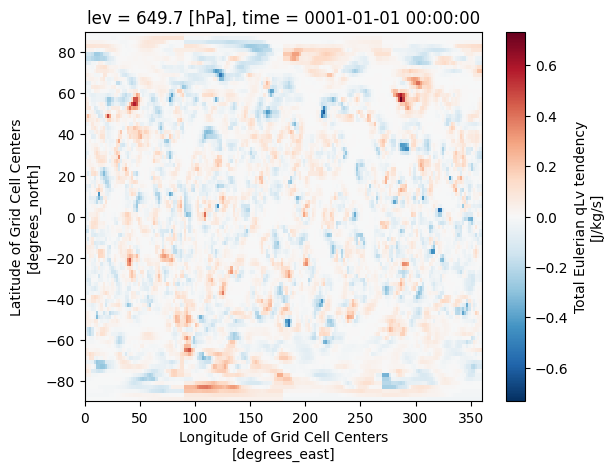

In [9]:
ds['DQLV_TOT'][0,-20,:,:].plot()

In [3]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 50

ndays = 200

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/3D/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])


In [9]:
T = ds['T'].sel(lat=slice(-lat_lim, lat_lim))
T

<xarray.DataArray 'T' (time: 200, lev: 60, lat: 50, lon: 180)>
dask.array<getitem, shape=(200, 60, 50, 180), dtype=float32, chunksize=(1, 60, 50, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -49.0 -47.0 -45.0 -43.0 -41.0 ... 43.0 45.0 47.0 49.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lev      (lev) float64 0.07835 0.1411 0.2529 0.4493 ... 963.6 978.0 992.6
  * time     (time) object 0009-10-29 00:00:00 ... 0010-05-16 00:00:00
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_methods:   time: mean
    cell_measures:  area: area

In [14]:
np.argmin(T.mean(dim=["time","lat","lon"]).values)

18

In [15]:
T['lev'][18].values 

array(94.630092)

In [23]:
int_mse = mjo.get_integrated_MSE(ds)

In [25]:
int_mse

<xarray.DataArray (time: 200, lat: 50, lon: 180)>
dask.array<sum-aggregate, shape=(200, 50, 180), dtype=float64, chunksize=(1, 50, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -49.0 -47.0 -45.0 -43.0 -41.0 ... 43.0 45.0 47.0 49.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) object 0009-10-29 00:00:00 ... 0010-05-16 00:00:00

In [26]:
mse_coef = mjo.MJO_regression(int_mse, olr)

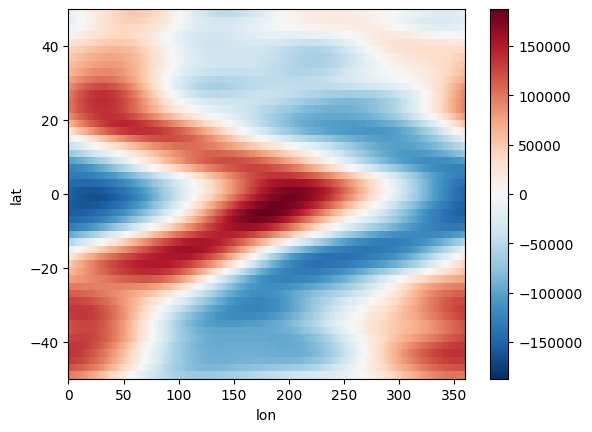

In [27]:
(-mse_coef * 40).plot()

In [4]:
mse = mjo.get_local_MSE(ds)

In [22]:
mse.sum(dim='lev')

<xarray.DataArray (time: 200, lat: 50, lon: 180)>
dask.array<sum-aggregate, shape=(200, 50, 180), dtype=float32, chunksize=(1, 50, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -49.0 -47.0 -45.0 -43.0 -41.0 ... 43.0 45.0 47.0 49.0
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) object 0009-10-29 00:00:00 ... 0010-05-16 00:00:00

In [ ]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 50

ndays = 200

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds1 = xr.open_mfdataset(nc_files[-ndays:])

olr = ds1['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean()

In [6]:
mse_coef = mjo.MJO_regression(mse, olr)

ValueError: operands could not be broadcast together with shapes (200,60,180) (200,1) 

In [ ]:
mse_coef.plot()

In [5]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 50

ndays = 200

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])

olr = ds['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean()

In [20]:
coef = mjo.MJO_regression(olr, olr)

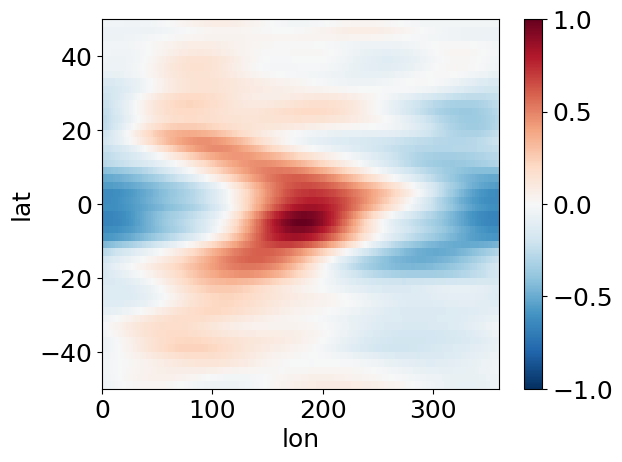

In [21]:
coef.plot()

In [4]:
wavfreq, wavwn = mjo.genDispersionCurves()

In [5]:
wavfreq.shape

(6, 3, 50)

Get the MJO composites

In [3]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

lat_lim = 50

ndays = 200

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-ndays:])

olr = ds['FLNT'].sel(lat=slice(-lat_lim,lat_lim)).resample(time='1D').mean()

In [4]:
# get MJO-filtered OLR
olr_flt = {}

for lat in olr['lat'].values:
    olr_flt[lat] = mjo.get_MJO_signal(olr.sel(lat=lat).load().squeeze()).real

In [5]:
filtered_olr = xr.DataArray(list(olr_flt.values()), 
                            coords=[list(olr_flt.keys()), olr['time'].values, olr['lon'].values], 
                            dims=['lat','time','lon']).transpose('time', 'lat', 'lon')

In [9]:
ndays = 200

In [10]:
kt_damped = int(np.rint(ndays/4))
varmax_lat_index = filtered_olr[kt_damped:-kt_damped,:,:].var(dim='time').mean(dim='lon').argmax()
varmax_lat = olr['lat'][varmax_lat_index].values

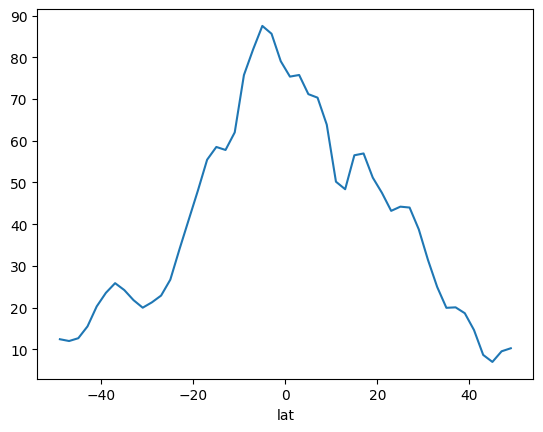

In [13]:
filtered_olr.var(dim='time').mean(dim='lon').plot()

In [15]:
olr_rolled = mjo.reorder_lon(filtered_olr[:, varmax_lat_index, :].squeeze())
olrref = np.concatenate([olr_rolled.sel(lon=lon_value).values for lon_value in olr_rolled['lon'].values])
del olr_rolled

In [39]:
olr_regcoef = xr.DataArray(
    data=np.zeros(filtered_olr[0,:,:].squeeze().shape),
    coords={
        'lat': filtered_olr['lat'].values,
        'lon': filtered_olr['lon'].values,
    },
    dims=['lat','lon'],
)

for lon in filtered_olr['lon'].values:
    olr_rolled = mjo.reorder_lon(filtered_olr, lon0=lon)
    olr_yaixs = np.concatenate([olr_rolled.sel(lon=lon_value).values for lon_value in olr_rolled['lon'].values])

    lon_index = np.where(filtered_olr['lon'].values == lon)[0]
    print('lon_index')

    coef = np.polyfit(olrref, olr_yaixs, deg=1)
    olr_regcoef[:,lon_index] = np.reshape(coef[0,:], (len(coef[0,:]),1))
    del olr_rolled

lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index
lon_index


Text(0.5, 1.0, 'MJO regressed OLR anomalies')

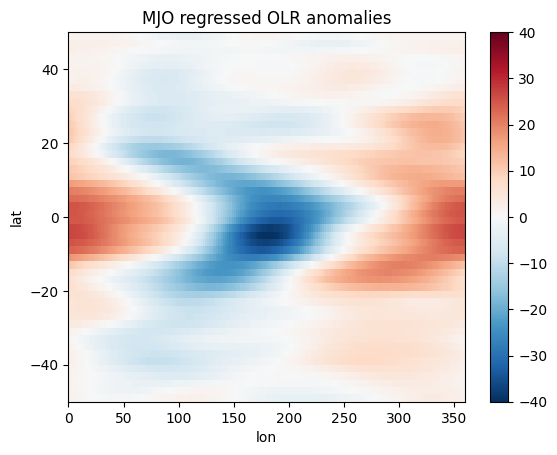

In [44]:
fig, ax = plt.subplots()
(-olr_regcoef * 40).plot(ax=ax)
ax.set_title('MJO regressed OLR anomalies')

Get the Hovmoller diagrams for the three datasets.

In [2]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'

# read all files in the case directory
import glob
files_path = dirn + case_dir + '/'

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files[-200:])


In [4]:
u850 = ds['U850'].sel(lat=slice(-10,10)).mean(dim='lat').resample(time='1D').mean()
olr = ds['FLNT'].sel(lat=slice(-10,10)).mean(dim='lat').resample(time='1D').mean()
prep = ds['PRECT'].sel(lat=slice(-10,10)).mean(dim='lat').resample(time='1D').mean()

In [5]:
import cftime
time_new = np.arange(1, len(u850['time'])+1)

u850 = u850.assign_coords(time=time_new)
olr = olr.assign_coords(time=time_new)
prep = prep.assign_coords(time=time_new)


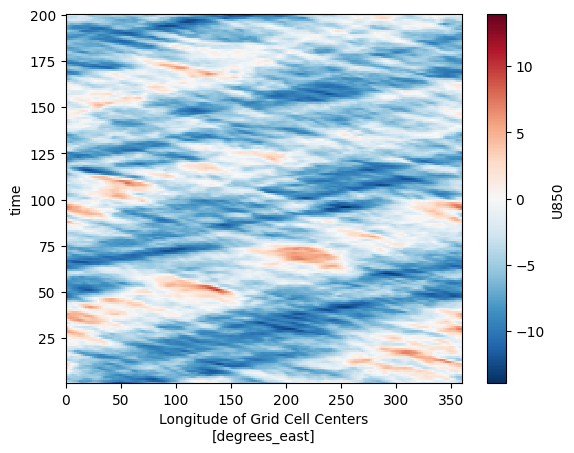

In [6]:
u850.plot()

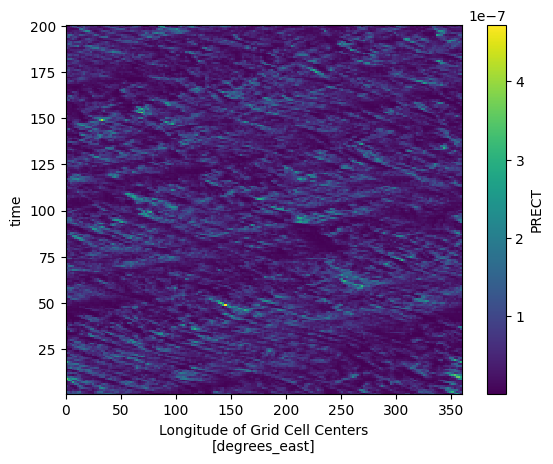

In [7]:
prep.plot()

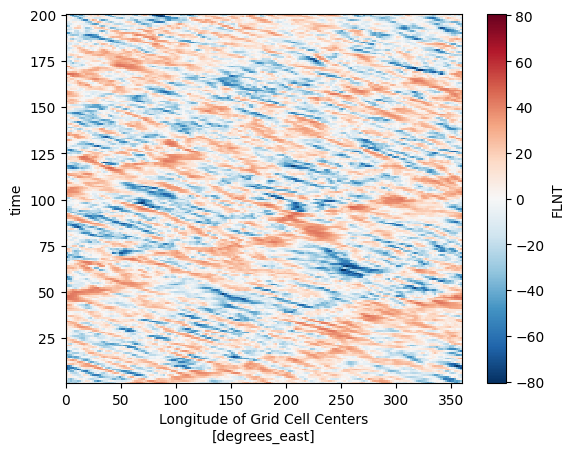

In [8]:
olrav = olr.mean(dim='time')

olrp = olr - olrav 
olrp.plot()

In [7]:
from scipy.signal import detrend
from MJO_E3SM_util import split_hann_taper

# get MJO-related signals by filtering the Wheeler-Kiladis spectra
def detrend_func(x):
    return detrend(x, axis=0)

def get_MJO_signal(u, d=1, kmin=1, kmax=5, flow=1/100.0, fhig=1/20.0, detrendflg=True):
    '''
    0. input u=u[time, lon]
    1. detrend the data.
    2. apply taper in time
    3. Fourier transform
    4. remove coefficients outside k=1-5, T=20-100 day
    5. reconstruct u 
    '''

    # detrend
    if detrendflg:
        u_detrended = xr.apply_ufunc(
            detrend_func,
            u,
            # input_core_dims=[['time']],
            # output_core_dims=[['time']],
            dask="parallelized",
            output_dtypes=[u.dtype],
        )
    else:
        u_detrended = u.copy()

    # taper
    # using hanning window w[n] = 0.5 * (1 - cos(2*pi*n/(M-1))) to create split cosine bell taper
    taper = split_hann_taper(seg_size=len(u['time']), fraction=0.5)

    u_detrend_tap = u_detrended * taper[:,None]

    # Fourier transform
    u_lon = np.fft.fft(u_detrend_tap, axis=1)
    u_lon[:,:kmin] = 0.0
    u_lon[:,kmax+1:-kmax] = 0.0

    u_lon_time = np.fft.fft(u_lon, axis=0)

    freq = np.fft.fftfreq(len(u['time']), d)
    tlow = np.argmin(np.abs(freq - flow))
    thig = np.argmin(np.abs(freq - fhig))

    u_lon_time[:tlow,:] = 0.0
    u_lon_time[thig+1:-thig,:] = 0.0
    u_lon_time[-tlow+1:,:] = 0.0

    u_lon_time[tlow:thig+1, kmin:kmax+1] = 0.0
    u_lon_time[-thig:-tlow+1, -kmax:] = 0.0

    # reconstruct u
    u_retime = np.fft.ifft(u_lon_time, axis=0)
    u_re = np.fft.ifft(u_retime, axis=1)

    return u_re

In [12]:
ude = get_MJO_signal(u850.load(), detrendflg=True)

u850_re = xr.DataArray(
    data=ude.real,
    coords=u850.coords,
    dims=u850.dims,
)

olrde = get_MJO_signal(olr.load(), detrendflg=True)

olr_re = xr.DataArray(
    data=olrde.real,
    coords=olr.coords,
    dims=olr.dims,
)

prepde = get_MJO_signal(prep.load(), detrendflg=True)

prep_re = xr.DataArray(
    data=prepde.real,
    coords=prep.coords,
    dims=prep.dims,
)


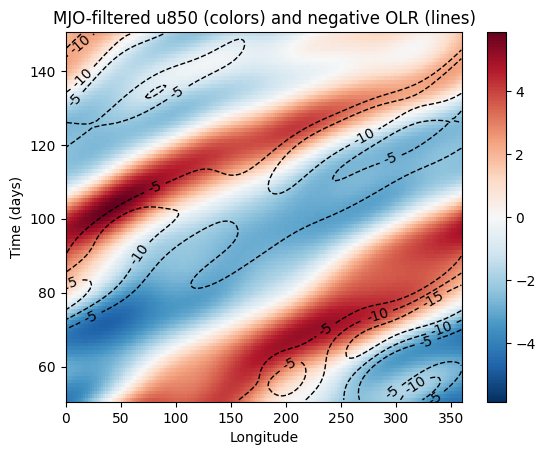

In [17]:
import matplotlib.pyplot as plt

ude = get_MJO_signal(u850.load(), detrendflg=True)

u850_re = xr.DataArray(
    data=ude.real,
    coords=u850.coords,
    dims=u850.dims,
)

olrde = get_MJO_signal(olr.load(), detrendflg=True)

olr_re = xr.DataArray(
    data=olrde.real,
    coords=olr.coords,
    dims=olr.dims,
)

prepde = get_MJO_signal(prep.load(), detrendflg=True)

prep_re = xr.DataArray(
    data=prepde.real,
    coords=prep.coords,
    dims=prep.dims,
)

fig, ax = plt.subplots()

# Plot u850 as a colored background
u850_re[50:150,:].plot(ax=ax, cmap='RdBu_r', add_colorbar=True)

# Add contours for negative OLR
# contour_levels = [-200, -150, -100, -50]  # customize this as needed
olr_contours = olr_re[50:150,:].where(olr_re[50:150,:] < 0).plot.contour(ax=ax, colors='k', levels=5, linewidths=1)

# Add contour labels if desired
plt.clabel(olr_contours, inline=True, fontsize=10, fmt='%1.0f')

# Add titles and labels
plt.title('MJO-filtered u850 (colors) and negative OLR (lines)')
plt.xlabel('Longitude')
plt.ylabel('Time (days)')

# Show the plot
plt.show()

In [13]:
# Define the time and longitude dimensions
n_time = 400
n_lon = 360
lon = np.arange(0, n_lon)
time = np.arange(0, n_time)

# Generate synthetic data for u
# Create a signal with k=3, T=50 days
k = 3
T = 50
angular_freq = 2 * np.pi / T
wavenumber = k

u_synthetic = np.sin(wavenumber * lon[None,:] * np.pi / 180 - angular_freq * time[:, None])

# Create an xarray DataArray
u = xr.DataArray(
    u_synthetic,
    coords={"lon": lon, "time": time},
    dims=["time","lon"]
)

# Apply your get_MJO_signal function
u_reconstructed = get_MJO_signal(u, d=1, kmin=1, kmax=5, flow=1/100.0, fhig=1/20.0, detrendflg=True)

# Analyze u_reconstructed to check how well it matches the input


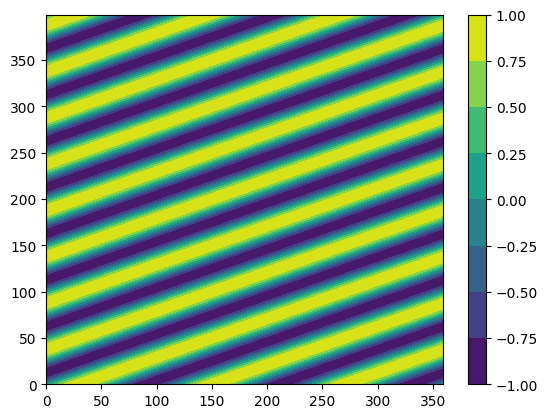

In [14]:
import matplotlib.pyplot as plt
plt.contourf(u_synthetic)
plt.colorbar()

/global/homes/l/linyaoly/.conda/envs/eofenv/lib/python3.9/site-packages/xarray/core/common.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self.values, dtype=dtype)


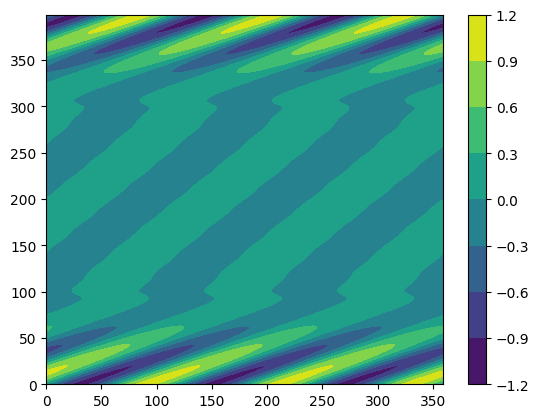

In [16]:
import matplotlib.pyplot as plt
plt.contourf(u_reconstructed-u)
plt.colorbar()

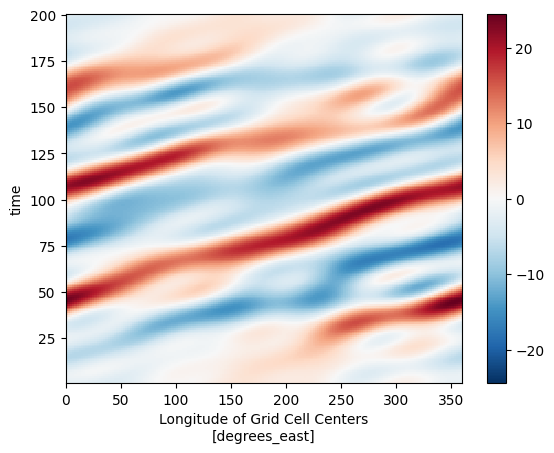

In [8]:
ude = get_MJO_signal(u850.load(), detrendflg=True)

u_re = xr.DataArray(
    data=ude.real,
    coords=u850.coords,
    dims=u850.dims,
)

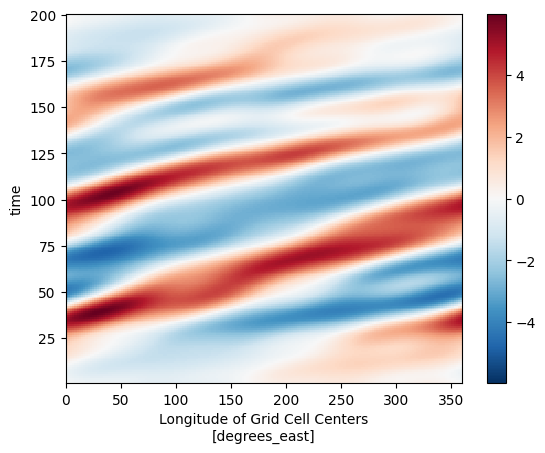

In [9]:
u_re.plot()

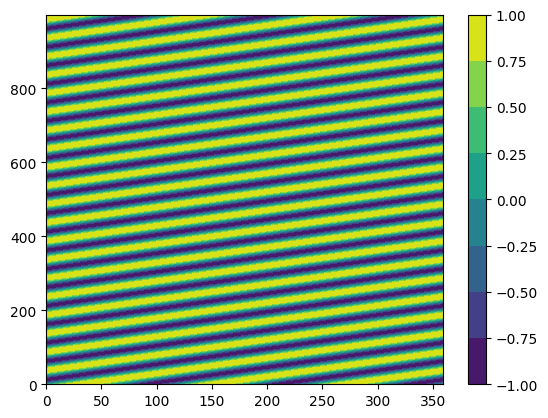

In [9]:
import matplotlib.pyplot as plt
plt.contourf(u)
plt.colorbar()

In [12]:
u_reconstructed

array([[ 1.72704834e-06-3.75594926e-17j,  2.15495850e-06-3.78591917e-17j,
         2.57727710e-06-3.80542916e-17j, ...,
         4.20067568e-07-3.60381161e-17j,  8.58562024e-07-3.66501140e-17j,
         1.29457089e-06-3.71551535e-17j],
       [ 4.52598852e-06-3.73824251e-17j,  4.88320207e-06-3.73224175e-17j,
         5.22756930e-06-3.71582437e-17j, ...,
         3.38543071e-06-3.69301236e-17j,  3.77625640e-06-3.71855958e-17j,
         4.15672948e-06-3.73366510e-17j],
       [ 6.73337102e-06-3.59027903e-17j,  6.96289768e-06-3.55149621e-17j,
         7.17412553e-06-3.50298946e-17j, ...,
         5.93916380e-06-3.64696869e-17j,  6.22104380e-06-3.63811569e-17j,
         6.48594034e-06-3.61918683e-17j],
       ...,
       [-6.48594034e-06-3.06327018e-17j, -6.22104380e-06-3.19411607e-17j,
        -5.93916380e-06-3.31612269e-17j, ...,
        -7.17412553e-06-2.62050192e-17j, -6.96289768e-06-2.77614166e-17j,
        -6.73337102e-06-2.92380730e-17j],
       [-4.15672948e-06-3.41456298e-17j, -3.

/global/homes/l/linyaoly/.conda/envs/eofenv/lib/python3.9/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


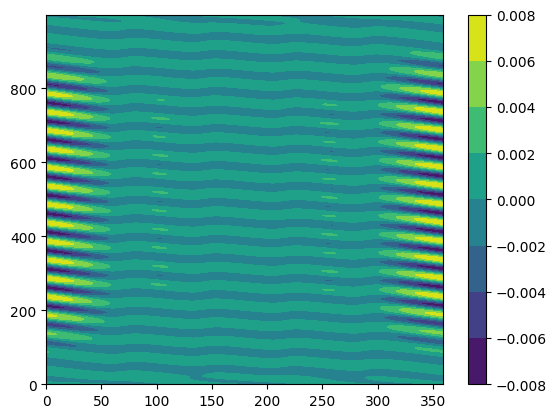

In [11]:
import matplotlib.pyplot as plt
plt.contourf(u_reconstructed)
plt.colorbar()

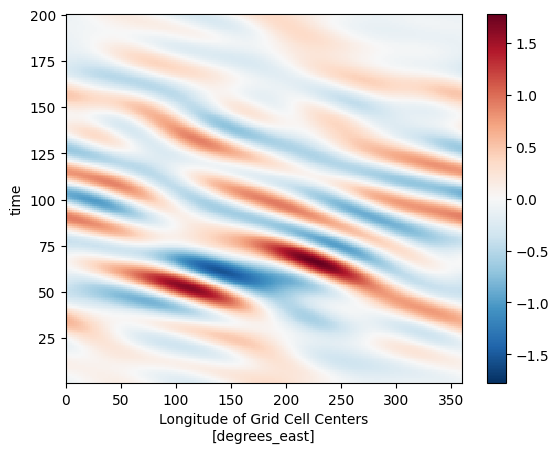

In [21]:
u_re.plot()

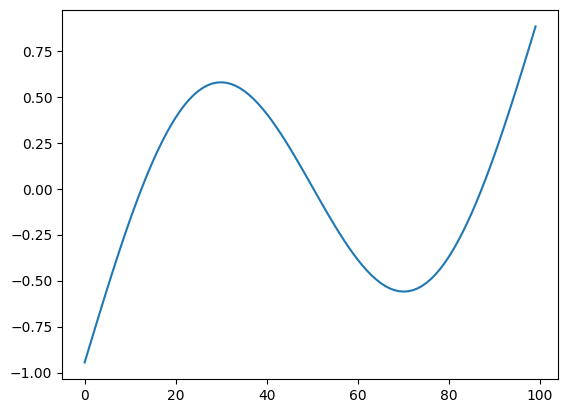

In [49]:
import matplotlib.pyplot as plt
x = np.reshape(np.arange(100), (100,1)) 
u =  np.sin(2 * np.pi * x / 100)
ulin = x
ud = get_MJO_signal(u)

plt.plot(ud)

In [44]:
u-ud

array([[ 0.94516384],
       [ 1.92606962],
       [ 2.9069754 ],
       [ 3.88788118],
       [ 4.86878696],
       [ 5.84969275],
       [ 6.83059853],
       [ 7.81150431],
       [ 8.79241009],
       [ 9.77331587],
       [10.75422165],
       [11.73512743],
       [12.71603321],
       [13.69693899],
       [14.67784477],
       [15.65875056],
       [16.63965634],
       [17.62056212],
       [18.6014679 ],
       [19.58237368],
       [20.56327946],
       [21.54418524],
       [22.52509102],
       [23.5059968 ],
       [24.48690258],
       [25.46780837],
       [26.44871415],
       [27.42961993],
       [28.41052571],
       [29.39143149],
       [30.37233727],
       [31.35324305],
       [32.33414883],
       [33.31505461],
       [34.29596039],
       [35.27686618],
       [36.25777196],
       [37.23867774],
       [38.21958352],
       [39.2004893 ],
       [40.18139508],
       [41.16230086],
       [42.14320664],
       [43.12411242],
       [44.1050182 ],
       [45

In [20]:
udetrend = get_MJO_signal(u850[:,0])

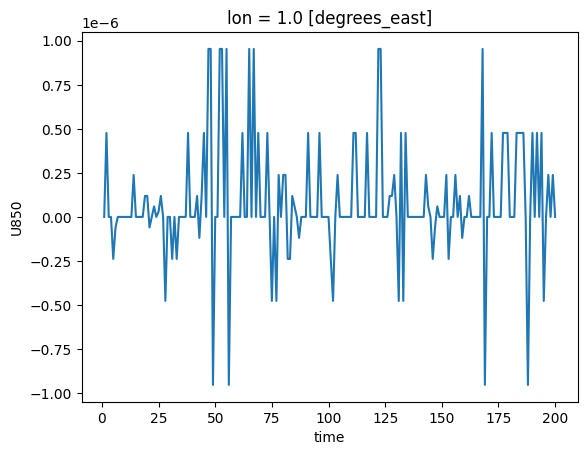

In [21]:
udetrend.plot()

Get the Wheeler-Kiladis diagram for OLR

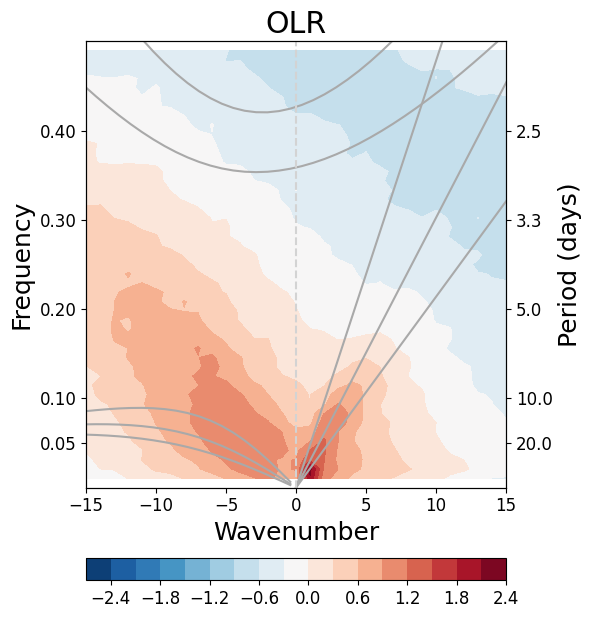

In [16]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'
ds_wk0 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput.nc')
mjo.wk_plot_sym(ds_wk0['sym'],tlt='OLR', logflg=True, pltDispCurve=True)

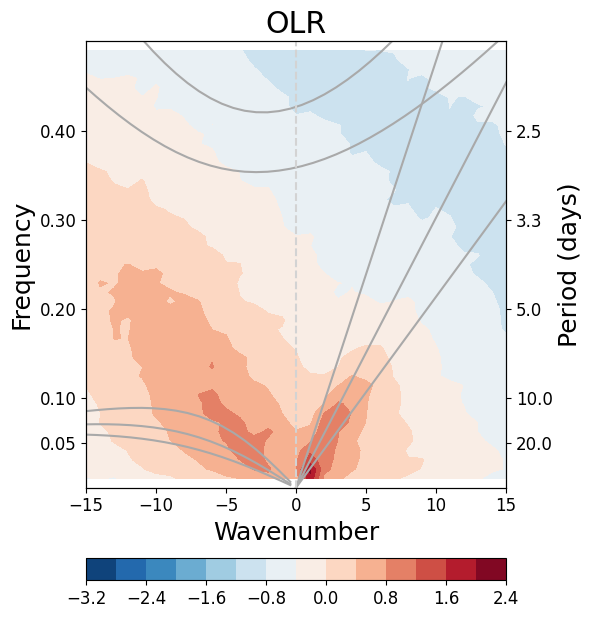

In [25]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'
ds_wk0 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput_all.nc')
mjo.wk_plot_sym(ds_wk0['sym'],tlt='OLR', logflg=True, pltDispCurve=True)

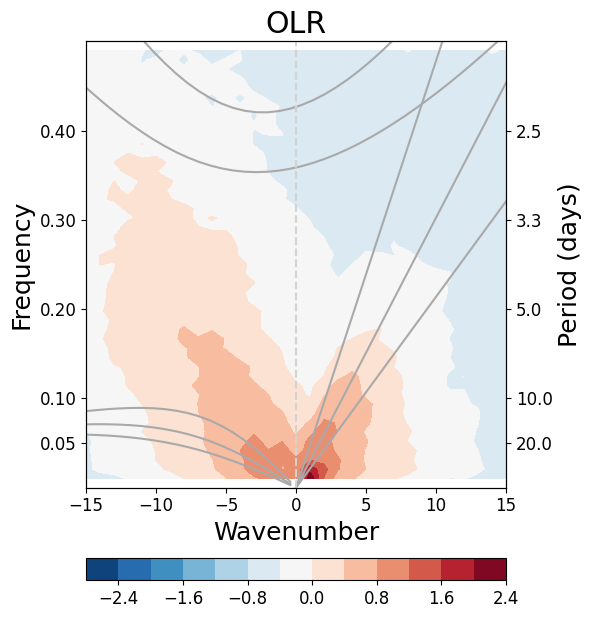

In [19]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'FIX_QRT'
ds_wk0 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput_all.nc')
mjo.wk_plot_sym(ds_wk0['sym'],tlt='OLR', logflg=True, pltDispCurve=True)

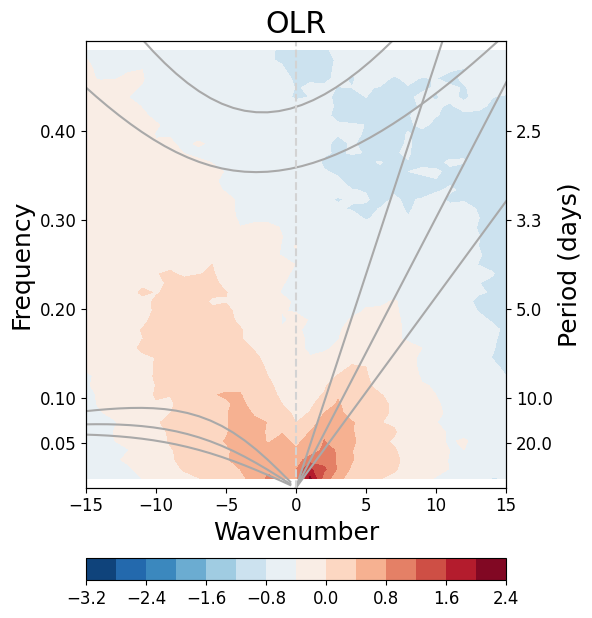

In [10]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'GBL_QRT'
ds_wk0 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput_all.nc')
mjo.wk_plot_sym(ds_wk0['sym'],tlt='OLR', logflg=True, pltDispCurve=True)

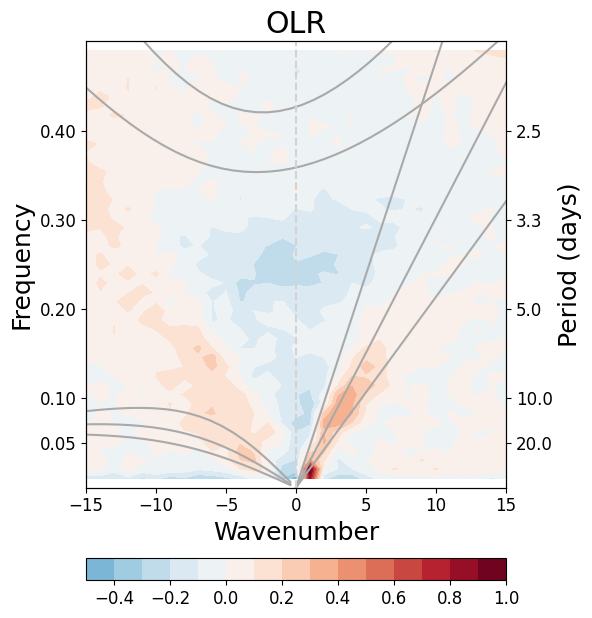

In [15]:
# directory that stores all case data
dirn = '/pscratch/sd/l/linyaoly/MJO_E3SM/regridded_data/'
# specify which case we use
case_dir = 'control'
ds_wk0 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput.nc')
mjo.wk_plot_sym(ds_wk0['sym_norm'],tlt='OLR', logflg=True, pltDispCurve=True, center0=True)

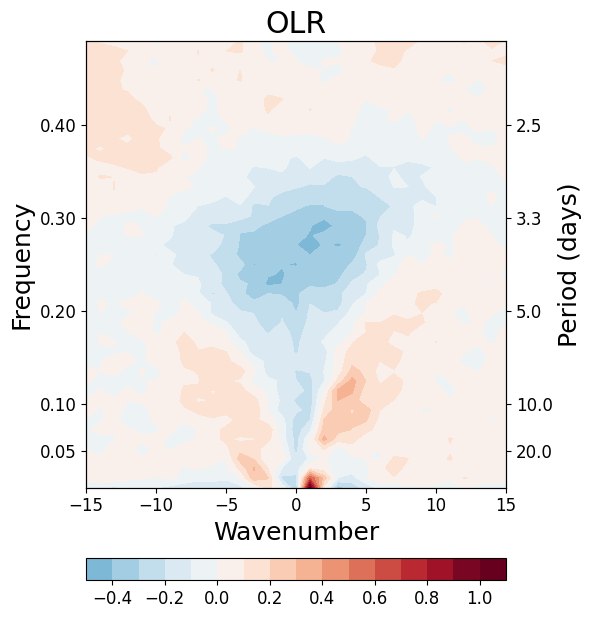

In [14]:
case_dir = 'FIX_QRT'
ds_wk1 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput.nc')
mjo.wk_plot_sym(ds_wk1['sym_norm'],tlt='OLR', logflg=True)

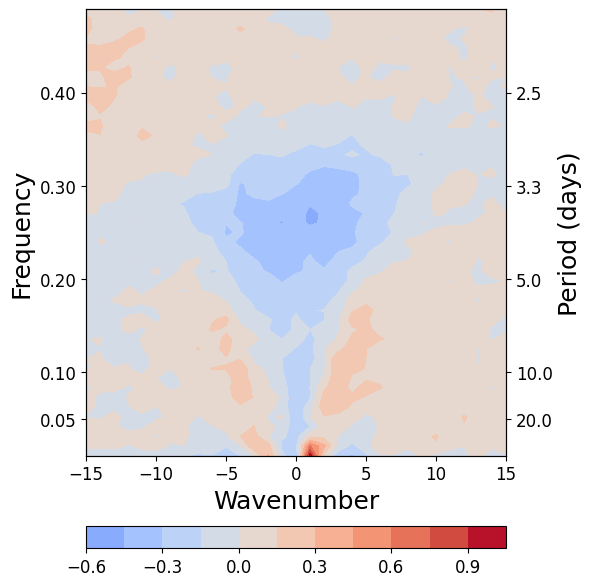

In [4]:
case_dir = 'GBL_QRT'
ds_wk2 = xr.open_dataset(dirn + '/analysis/' + case_dir + '_OLR_wk_dailyinput.nc')
MJO_E3SM_util.wk_plot_sym(ds_wk2['sym_norm'], logflg=True)

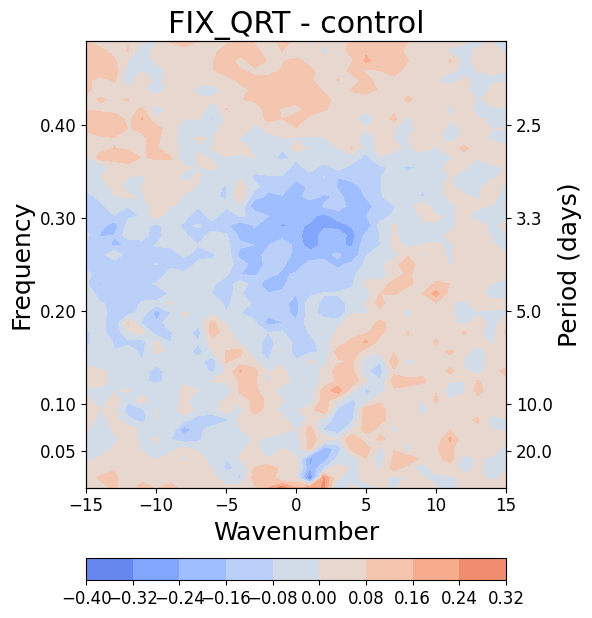

In [12]:
plot_data = np.log10(ds_wk1['sym_norm']) - np.log10(ds_wk0['sym_norm'])
tlt = 'FIX_QRT - control'
wavenumber = ds_wk2['wavenumber']
frequency = ds_wk2['frequency']

import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 18})

# Create a figure and subplots
fig = plt.figure(figsize=(13, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.05], width_ratios=[1, 1])

# Plot smooth_sym for each frequency
ax = fig.add_subplot(gs[0, 0])
c = ax.contourf(wavenumber, frequency, plot_data.T, cmap='coolwarm', levels=10, vmin=-0.5, vmax=0.5)

ax.set_xlabel('Wavenumber')
ax.set_ylabel('Frequency')
ax.set_title(tlt)
ax.set_xlim(-15, 15)
ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.4])
# Customize tick labels
ax.tick_params(axis='both', labelsize=12)

cax = fig.add_subplot(gs[1, 0])

cbar = plt.colorbar(c, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=12)

# Create a twin axis for the second y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Period (days)')

# Modify tick labels for the second y-axis
ax2.set_ylim(ax.get_ylim())  # Match the y-axis limits with the first y-axis
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels([f'{1/freq:.1f}' if freq != 0 else '0' for freq in ax.get_yticks()])
# Customize tick labels
ax2.tick_params(axis='both', labelsize=12)

# Adjust the spacing between subplots and colorbars
plt.subplots_adjust(wspace=0.4, hspace=0.3)

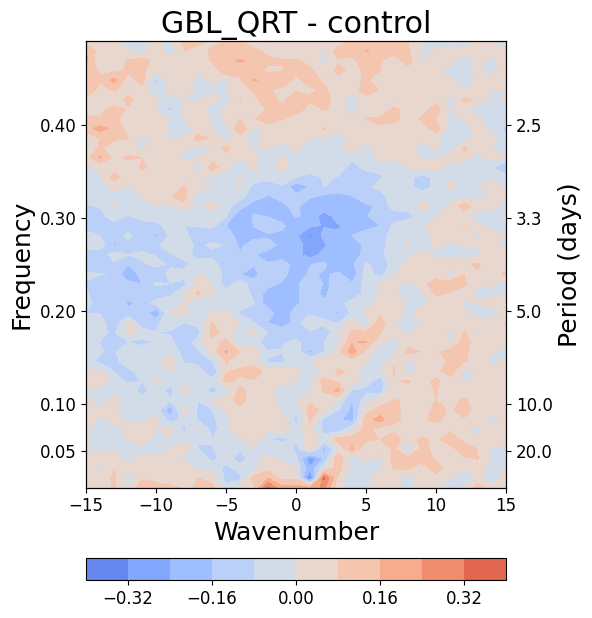

In [11]:
plot_data = np.log10(ds_wk2['sym_norm']) - np.log10(ds_wk0['sym_norm'])
tlt = 'GBL_QRT - control'
wavenumber = ds_wk2['wavenumber']
frequency = ds_wk2['frequency']

import matplotlib.pyplot as plt 

plt.rcParams.update({'font.size': 18})

# Create a figure and subplots
fig = plt.figure(figsize=(13, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.05], width_ratios=[1, 1])

# Plot smooth_sym for each frequency
ax = fig.add_subplot(gs[0, 0])
c = ax.contourf(wavenumber, frequency, plot_data.T, cmap='coolwarm', levels=10, vmin=-0.5, vmax=0.5)

ax.set_xlabel('Wavenumber')
ax.set_ylabel('Frequency')
ax.set_title(tlt)
ax.set_xlim(-15, 15)
ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.4])
# Customize tick labels
ax.tick_params(axis='both', labelsize=12)

cax = fig.add_subplot(gs[1, 0])

cbar = plt.colorbar(c, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=12)

# Create a twin axis for the second y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Period (days)')

# Modify tick labels for the second y-axis
ax2.set_ylim(ax.get_ylim())  # Match the y-axis limits with the first y-axis
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels([f'{1/freq:.1f}' if freq != 0 else '0' for freq in ax.get_yticks()])
# Customize tick labels
ax2.tick_params(axis='both', labelsize=12)

# Adjust the spacing between subplots and colorbars
plt.subplots_adjust(wspace=0.4, hspace=0.3)

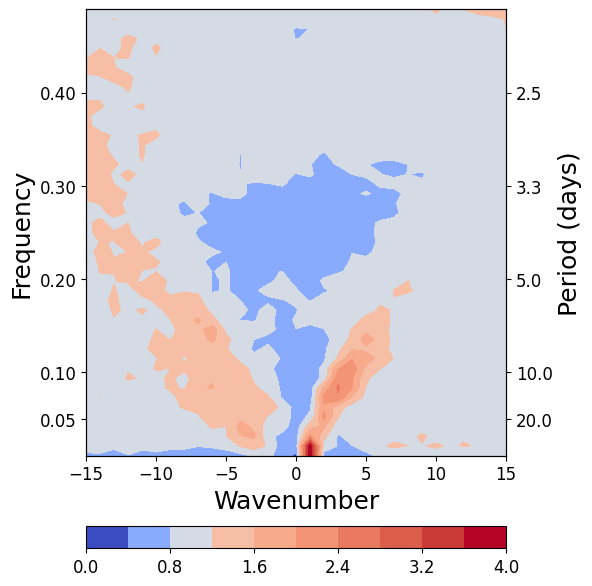

In [3]:
ds_wk = xr.open_dataset(dirn + 'analysis/control_OLR_wk_dailyinput_wormvlow.nc')
ds_wk['sym_norm'] = ds_wk['sym_norm'].where(ds_wk['sym_norm'] <= 4, 4)
MJO_E3SM_util.wk_plot_sym(ds_wk['sym_norm'], logflg=False)

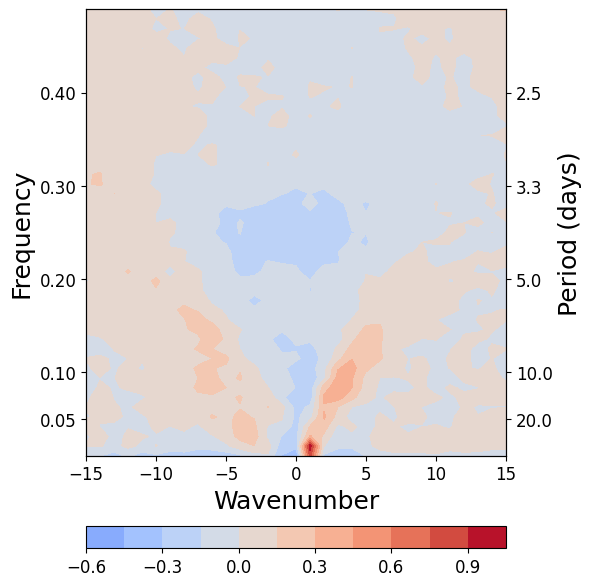

In [4]:
ds_wk = xr.open_dataset(dirn + 'analysis/control_OLR_wk_dailyinput.nc')
# ds_wk['sym_norm'] = ds_wk['sym_norm'].where(ds_wk['sym_norm'] >= 1, np.nan)
MJO_E3SM_util.wk_plot_sym(ds_wk['sym_norm'], logflg=True)

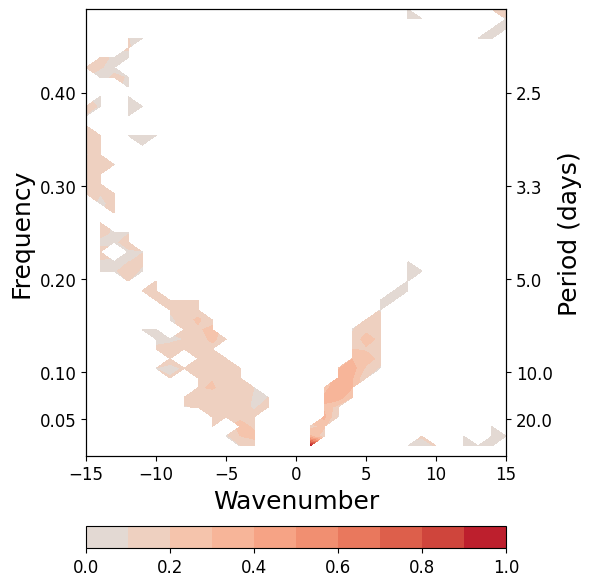

In [9]:
MJO_E3SM_util.wk_plot_sym(ds_wk['sym_sig'], logflg=True)

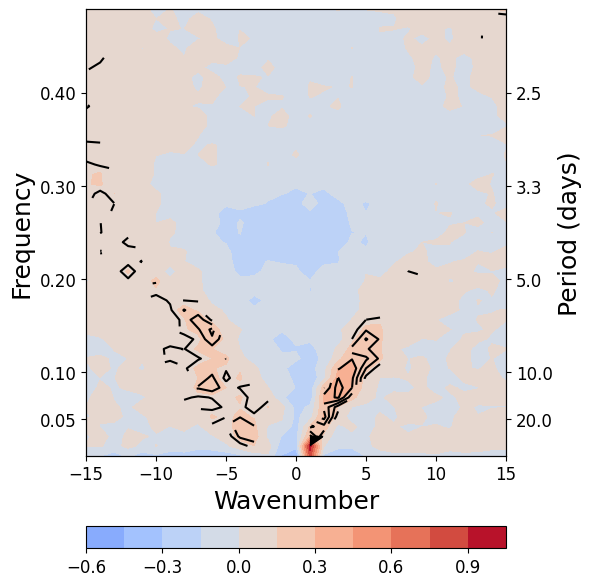

In [5]:
MJO_E3SM_util.wk_plot_symsig(ds_wk['sym_norm'], np.log10(ds_wk['sym_sig']))

In [4]:
ds_wk['frequency']

<xarray.DataArray 'frequency' (frequency: 47)>
array([0.010417, 0.020833, 0.03125 , 0.041667, 0.052083, 0.0625  , 0.072917,
       0.083333, 0.09375 , 0.104167, 0.114583, 0.125   , 0.135417, 0.145833,
       0.15625 , 0.166667, 0.177083, 0.1875  , 0.197917, 0.208333, 0.21875 ,
       0.229167, 0.239583, 0.25    , 0.260417, 0.270833, 0.28125 , 0.291667,
       0.302083, 0.3125  , 0.322917, 0.333333, 0.34375 , 0.354167, 0.364583,
       0.375   , 0.385417, 0.395833, 0.40625 , 0.416667, 0.427083, 0.4375  ,
       0.447917, 0.458333, 0.46875 , 0.479167, 0.489583])
Coordinates:
  * frequency  (frequency) float64 0.01042 0.02083 0.03125 ... 0.4792 0.4896

In [3]:
# read all files in the case directory
import glob
files_path = dirn + case_dir

# Find all .nc files in the directory
nc_files = sorted(glob.glob(f"{files_path}/*.nc"))

ds = xr.open_mfdataset(nc_files)


In [4]:
sym, asym, background, sym_norm, asym_norm, sym_sig, asym_sig = MJO_E3SM_util.wk_analysis(ds['FLNT'].resample(time='D').mean(), spd=1)


size of taper:  (96,)
(6, 179, 47)
(179, 47)


In [5]:
# Create a new Dataset that contains each DataArray
output_ds = xr.Dataset({
    'sym': sym,
    'asym': asym,
    'background': background,
    'sym_norm': sym_norm,
    'asym_norm': asym_norm,
    'sym_sig': sym_sig,
    'asym_sig': asym_sig
})

# Specify path for saving the NetCDF file
output_path = dirn + 'analysis/'

import os

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the Dataset as a NetCDF file
nc_file_path = output_path+'control_wk_plot.nc'
# Check if the file exists
if os.path.exists(nc_file_path):
    # Delete the file
    os.remove(nc_file_path)
output_ds.to_netcdf(nc_file_path)

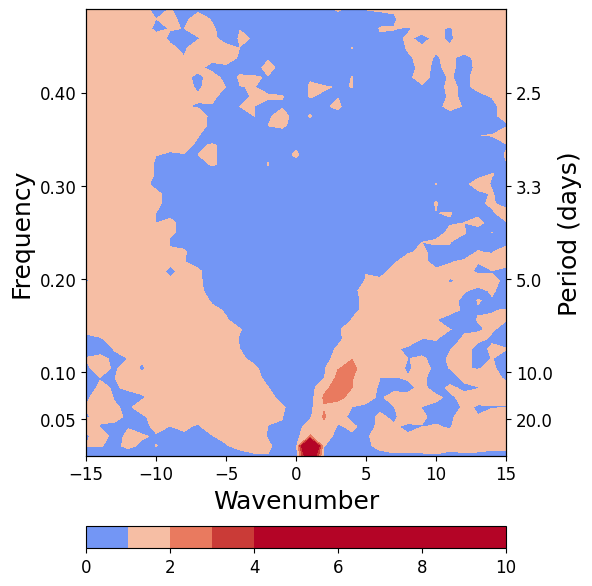

In [10]:
ds_wk = xr.open_dataset(dirn + 'analysis/control_OLR_wk_dailyinput.nc')

MJO_E3SM_util.wk_plot_sym(ds_wk['sym_norm'], logflg=False)
# MJO_E3SM_util.wk_plot_symsig(ds_wk['sym_norm'], ds_wk['sym_sig'])

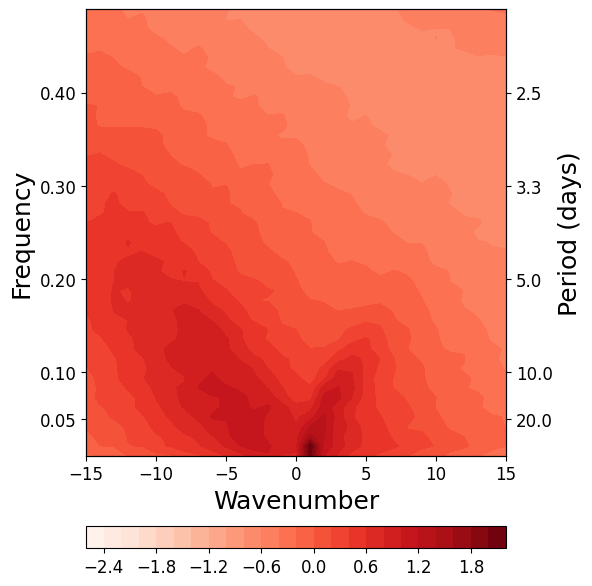

In [8]:
ds_wk = xr.open_dataset(dirn + 'analysis/control_OLR_wk_dailyinput.nc')

MJO_E3SM_util.wk_plot_sym(ds_wk['sym'])
# MJO_E3SM_util.wk_plot_symsig(ds_wk['sym_norm'], ds_wk['sym_sig'])

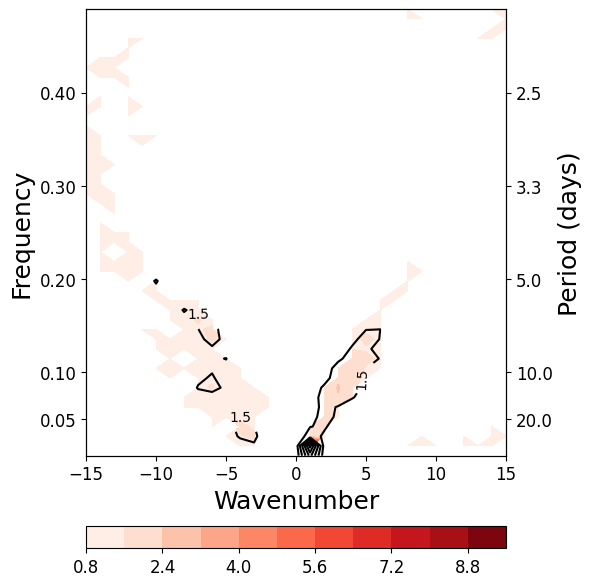

In [11]:
MJO_E3SM_util.wk_plot_symsig(ds_wk['sym_norm'], ds_wk['sym_sig'])

In [8]:
ds_wk.frequency

<xarray.DataArray 'frequency' (frequency: 47)>
array([0.010417, 0.020833, 0.03125 , 0.041667, 0.052083, 0.0625  , 0.072917,
       0.083333, 0.09375 , 0.104167, 0.114583, 0.125   , 0.135417, 0.145833,
       0.15625 , 0.166667, 0.177083, 0.1875  , 0.197917, 0.208333, 0.21875 ,
       0.229167, 0.239583, 0.25    , 0.260417, 0.270833, 0.28125 , 0.291667,
       0.302083, 0.3125  , 0.322917, 0.333333, 0.34375 , 0.354167, 0.364583,
       0.375   , 0.385417, 0.395833, 0.40625 , 0.416667, 0.427083, 0.4375  ,
       0.447917, 0.458333, 0.46875 , 0.479167, 0.489583])
Coordinates:
  * frequency  (frequency) float64 0.01042 0.02083 0.03125 ... 0.4792 0.4896

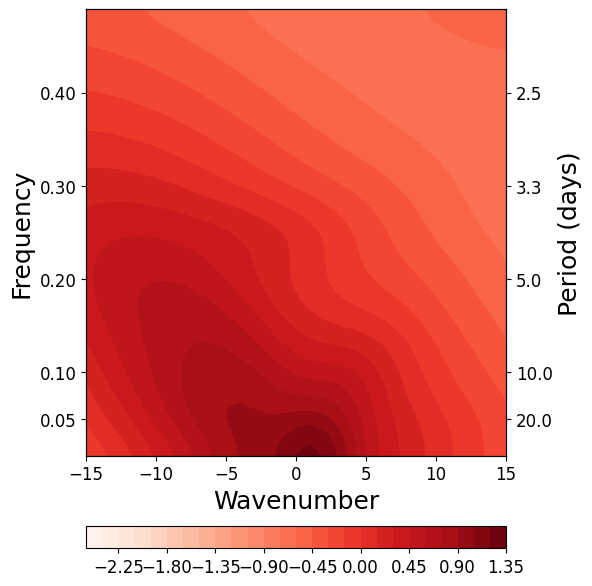

In [9]:
MJO_E3SM_util.wk_plot_sym(ds_wk['background'])